# MMIA - Master Degree Thesis

## Predictions for long duration trail running activities

## Data Processing

The data processing logic is implemented in the `DataProcessor` class within the file [data_processor.py](utils/data_processor.py). The recording device is a Polar Vantage V watch. Polar data is structured in JSON format, so it's essential to convert it into a tabular format before feeding it into the model.

This processing involves extracting and transforming information from JSON files containing trail running activity records. The script filters activities by sport type (`TRAIL_RUNNING`) and duration (between 4 and 6 hours). For each valid activity, sensor samples, such as heart rate, altitude, distance, temperature, cadence, and speed, are extracted.

These samples are organized into a DataFrame, where several feature engineering tasks are performed:

- **Distance**: The difference between consecutive samples is computed to obtain interval-by-interval progress.  
- **Altitude**: The data is smoothed, and elevation differences, cumulative ascent, and cumulative descent are calculated.  
- **Duration**: Cumulative time between samples is computed.

Processing is performed efficiently, supporting multithreading to accelerate file conversion. The resulting processed data is saved into structured CSV files, ready for analysis and modeling.

### Data Resampling

The goal of the project is to predict race time, so the data was resampled to ensure samples are spaced at constant distance intervals. The resampling logic is implemented in the `DataResampler` class in the file [data_resampling.py](./utils/data_resampling.py).

The activity data files from the previous step were transformed so that samples are evenly spaced at fixed distance intervals (every 5 meters). This process included:

- Loading the data and converting the timestamp column to datetime format.  
- Filling missing values in heart rate, cadence, speed, and distance using either the mean or the previous value.  
- Removing duplicates and creating a new distance-based index with 2-meter steps.  
- Interpolating values to obtain continuous data at these regular intervals.  
- Saving the resampled data as CSV files in an output folder.

### Exploratory Data Analysis

In [12]:
# Import requiered libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

# Define the directory containing the processed data
data_dir = "./data/resampled"
# Get the training files list
training_files=os.listdir(data_dir)

# Get the files count
print(f"Number of training files: {len(training_files)}")

Number of training files: 101


In [13]:
# Load and process all CSV files
data_frames = []
for file_name in training_files:
    file_path = os.path.join(data_dir, file_name)
    df = pd.read_csv(file_path)
    data_frames.append(df)

# Combine all data
data = pd.concat(data_frames, ignore_index=True)

# Display basic information about the dataset
print(data.info())

# Display summary statistics
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453667 entries, 0 to 453666
Data columns (total 19 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   distance                     453667 non-null  float64
 1   timestamp                    453667 non-null  object 
 2   heartRate                    453667 non-null  float64
 3   altitude                     453667 non-null  float64
 4   altitude_raw                 453667 non-null  float64
 5   temperature                  453667 non-null  float64
 6   cadence                      453667 non-null  float64
 7   speed                        453667 non-null  float64
 8   duration                     453667 non-null  float64
 9   elevation_diff               453667 non-null  float64
 10  elevation_gain               453667 non-null  float64
 11  elevation_loss               453667 non-null  float64
 12  duration_diff                453667 non-null  float64
 13 

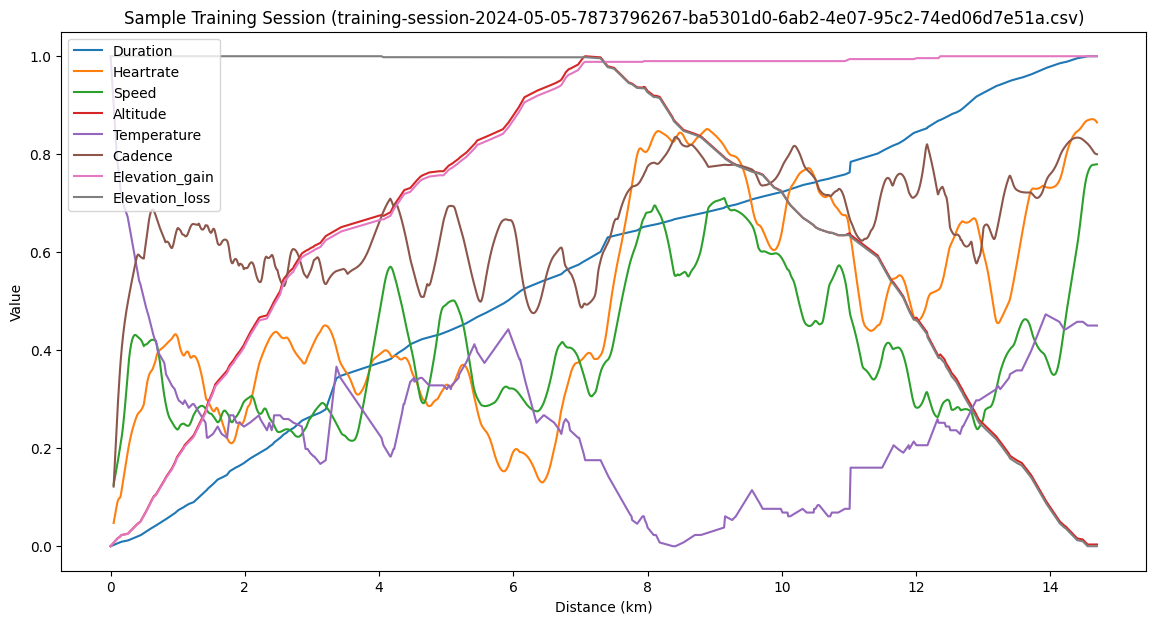

In [14]:
# Plot heart rate over distance
random.seed(4242)
sample_file = random.choice(training_files)
sample_path = os.path.join(data_dir, sample_file)
sample_data = pd.read_csv(sample_path)

#Normalize sample data (scale between 0 and 1 for better visualization)
normalized_cols = {}
for col in ['duration', 'heartRate', 'speed', 'altitude', 'temperature', 'cadence', 'elevation_gain', 'elevation_loss']:
    normalized_cols[col] = (sample_data[col] - sample_data[col].min()) / (sample_data[col].max() - sample_data[col].min())

# Smooth speed data using rolling average for visualization
normalized_cols['speed'] = normalized_cols['speed'].rolling(window=100, min_periods=10).mean()
normalized_cols['heartRate'] = normalized_cols['heartRate'].rolling(window=100, min_periods=10).mean()
normalized_cols['cadence'] = normalized_cols['cadence'].rolling(window=100, min_periods=10).mean()

plt.figure(figsize=(14, 7))
distance_km = sample_data['distance'] / 1000
for col in normalized_cols:
    plt.plot(distance_km, normalized_cols[col], label=col.capitalize())

plt.xlabel('Distance (km)')
plt.ylabel('Value')
plt.title(f'Sample Training Session ({sample_file})')
plt.legend()
plt.show()


At a glance, certain correlations between some of the variables can be observed. We expect the TFT model will then select the most appropriate variables for the case.

### DataModule

The `TFTDataModule` class was implemented using PyTorch Lightning’s `LightningDataModule` and the `TimeSeriesDataSet` class from the `pytorch-forecasting` library, which is specifically designed for time series modeling.

#### Data Loading

The module loads data automatically. The `prepare_data` function reads all available data and performs necessary preprocessing steps to integrate it with `pytorch-forecasting` components. For example, session identifiers are added as a categorical variable, and distance values are converted into a sequential `time_idx`, which is required by `TimeSeriesDataSet`.

#### Data Splitting

Initially, the data was split temporally into 70:15:15 proportions for training, validation, and test sets, respectively, following standard best practices for time series to prevent data leakage from future to past during validation and testing. However, since the project’s goal is to enable the model to handle *cold-start* scenarios (i.e., predicting before the athlete has even begun the route), the split was instead performed by session rather than by time, using a 75:15:10 ratio to provide slightly more context for training.

The DataModule implementation also includes:

- **Group-wise normalization**: Applies a `GroupNormalizer` per session to improve generalization.  
- **Future covariates handling**: Distinguishes between known and unknown future variables.

**Key configurable parameters:**
- `max_encoder_length`: Maximum encoder length (20 steps)  
- `max_prediction_length`: Prediction horizon (200 steps)  
- `batch_size`: Training batch size (64)  
- `target`: Target variable(s) to predict (`duration_diff`, `heart_rate`, `temperature`, `cadence`)

**Known future-dependent variables** (available at prediction time):  
- `altitude`: Altitude  
- `elevation_diff`: Elevation difference  
- `elevation_gain`: Cumulative elevation gain  
- `elevation_loss`: Cumulative elevation loss  
- `distance`: Distance covered  

**Unknown future-dependent variables:**  
- `duration_diff`: Interval duration  
- `heartRate`: Heart rate  
- `temperature`: Temperature  
- `cadence`: Cadence  
- `speed`: Speed  

The underlying hypothesis is that, when provided with appropriate contextual information about the terrain and route, the Temporal Fusion Transformer (TFT) model will be able to generate highly accurate predictions of race completion time.

In [15]:
# Import the TFT DataModule
# import sys
# sys.path.append('./utils')
from lib.data import TFTDataModule

# Create and setup the TFT data module
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=2,
    max_encoder_length=400,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup the data
data_module.setup()


Loading 101 training session files...
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']
Training samples: 352055
Validation samples: 77617
Test samples: 11


In [16]:
# Get a sample batch to understand the data structure
train_loader = data_module.train_dataloader()
sample_batch = next(iter(train_loader))

print(f"\nBatch structure:")
print(f"Batch type: {type(sample_batch)}")
print(f"Input features shape: {sample_batch[0]['encoder_cont'].shape}")  # [batch_size, encoder_length, features]
print(f"Target length: {len(sample_batch[1][0])}")          # Number of target variables
print(f"Target variable shape: {sample_batch[1][0][2].shape}")    # [batch_size, prediction_length]


Batch structure:
Batch type: <class 'tuple'>
Input features shape: torch.Size([64, 400, 21])
Target length: 4
Target variable shape: torch.Size([64, 200])


## Modelo

### Temporal Fusion Transformer (TFT)

The **Temporal Fusion Transformer** (TFT) is a deep learning model specifically designed for time series forecasting that can handle both known and unknown future variables.

Initially, a custom architecture was implemented within the `TrailRunningTFT` class, focused on predicting race time for trail running activities, structured as a *PyTorch Lightning* module. This involved instantiating the `TemporalFusionTransformer` model from the `pytorch-forecasting` library inside the custom class. However, since the `TemporalFusionTransformer` class is already implemented as a native *PyTorch Lightning* module, this extra wrapping proved unnecessary. Instead, the approach was revised to directly extend the existing `TemporalFusionTransformer` class, allowing domain-specific customizations tailored to trail running activities.

**Model characteristics:**
- **Architecture**: Based on the Temporal Fusion Transformer, optimized for sequential (time series) data  
- **Known future variables**: `altitude`, `elevation_diff`, `elevation_gain`, `elevation_loss`, `distance_diff` (available at prediction time)  
- **Unknown future variables**: `duration`, `heartRate`, `temperature`, `cadence`, `speed`  
- **Target variables**: `duration`, `heartRate`, `temperature`, `cadence`, `speed`  
- **Input sequence length**: 1–20 time steps  
- **Prediction horizon**: 200 steps into the future

## Finding optimal learning rate



Loading 101 training session files...
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']
Training samples: 352205
Validation samples: 77647
Test samples: 11
Initialized MultiLoss with target weights:
  duration_diff: 85.0%
  heartRate: 5.0%
  temperature: 5.0%
  cadence: 5.0%


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Starting learning rate finder...
This will test different learning rates to find the optimal one.
(Using single GPU to avoid multi-GPU segmentation fault)



Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO: Restoring states from the checkpoint path at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_b475e395-c425-4fe8-bbfb-d05956b61260.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_b475e395-c425-4fe8-bbfb-d05956b61260.ckpt
INFO: Restored all states from the checkpoint at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_b475e395-c425-4fe8-bbfb-d05956b61260.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /home/eaguayo/DeepLearning/ProyectoFinal/.lr_find_b475e395-c425-4fe8-bbfb-d05956b61260.ckpt
INFO: Learning rate set to 2.137962089502232e-05
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 2.137962089502232e-05



Suggested learning rate: 2.137962089502232e-05



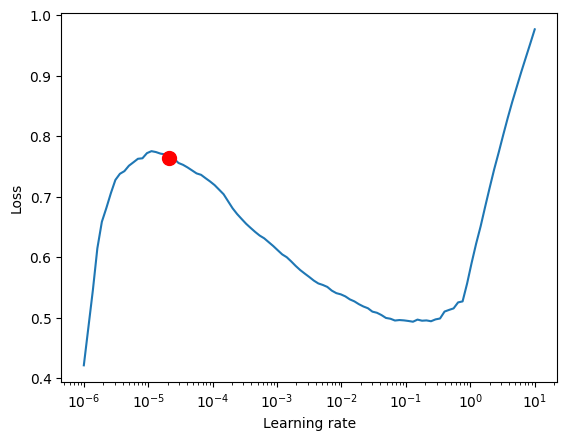

In [17]:
# Find optimal learning rate using PyTorch Lightning Tuner
# NOTE: Using single GPU to avoid SIGSEGV error with multi-GPU distributed strategy
import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import CSVLogger
from lib.model import TrailRunningTFT

# Create a fresh data module instance for learning rate finder
lr_data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=1,
    max_encoder_length=400,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup data
lr_data_module.setup(stage="fit")

# Create model instance for learning rate tuning
# Using same configuration as training.py
tft = TrailRunningTFT.from_dataset(
    lr_data_module.training,
    hidden_size=64,
    learning_rate=0.0005,  # Initial learning rate (will be tuned)
    output_size=[1] * 4,  # Multi-target output: duration_diff, heartRate, temperature, cadence
)

# Create a trainer for learning rate finder
# IMPORTANT: Using single GPU (devices=1) to avoid multi-GPU SIGSEGV error
# The lr_find uses a different training loop that can conflict with distributed strategies
logger = CSVLogger("logs", name="tft_lr_finder")

trainer = pl.Trainer(
    max_epochs=100,  # lr_find will use a subset
    accelerator='auto',
    devices=1,  # Single GPU - avoids SIGSEGV with distributed strategy
    logger=logger,
    gradient_clip_val=0.1,
    enable_checkpointing=False,  # No checkpoints needed for LR finding
    precision="32-true",  # Same as training.py
)

# Run learning rate finder
print("Starting learning rate finder...")
print("This will test different learning rates to find the optimal one.")
print("(Using single GPU to avoid multi-GPU segmentation fault)\n")

tuner = Tuner(trainer)

lr_finder = tuner.lr_find(
    tft,
    train_dataloaders=lr_data_module.train_dataloader(),
    val_dataloaders=lr_data_module.val_dataloader(),
    max_lr=10.0,
    min_lr=1e-6,
    num_training=100,  # Number of learning rate steps to test
)

# Display results
print(f"\n{'='*60}")
print(f"Suggested learning rate: {lr_finder.suggestion()}")
print(f"{'='*60}\n")

# Plot the learning rate finder results
fig = lr_finder.plot(show=True, suggest=True)
fig.show()


## Hyperparmeter optimization

In [18]:
# Hyperparameter Optimization using Optuna
# Running as external script for better resource management

import subprocess
import sys
import os
import pickle

# Path to the hyperparameter optimization script
script_path = "hyperparameter_optimization.py"
output_path = "./optuna_study_broader.pkl"

print("="*80)
print("LAUNCHING HYPERPARAMETER OPTIMIZATION")
print("="*80)
print(f"Script: {script_path}")
print(f"Configuration: 20 trials, max 50 epochs per trial")
print(f"Using single GPU (Optuna's dynamic sampling incompatible with multi-GPU DDP)")
print(f"Output will be saved to: {output_path}")
print("="*80 + "\n")

try:
    execute = False
    if not execute:
        print("Execution flag set to False. Skipping optimization script execution.")
    else:
        # Execute the script with subprocess
        process = subprocess.Popen(
            [sys.executable, script_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            universal_newlines=True,
            bufsize=1
        )
        
        # Display output in real-time
        for line in process.stdout:
            print(line.rstrip())
        
        # Wait for process to complete
        process.wait()
    
    if not execute or (process and process.returncode == 0):
        print("\n" + "="*80)
        print("HYPERPARAMETER OPTIMIZATION COMPLETED SUCCESSFULLY!")
        print("="*80 + "\n")
        
        # Load and display the results
        study_path = "./optuna_study_broader.pkl"
        if os.path.exists(study_path):
            with open(study_path, "rb") as f:
                study = pickle.load(f)
            
            print("Best hyperparameters summary:")
            print("=" * 80)
            for param, value in study.best_trial.params.items():
                print(f"  {param:35}: {value}")
            print("=" * 80)
            print(f"\nBest validation loss: {study.best_trial.value:.6f}")
            print(f"Best trial number: {study.best_trial.number}")
            print(f"Total trials: {len(study.trials)}")
        else:
            print(f"Warning: Could not find {study_path} to load results")
    else:
        print("\n" + "="*80)
        print(f"ERROR: Optimization failed with exit code {process.returncode}")
        print("="*80)

except Exception as e:
    print(f"\nError running optimization script: {str(e)}")
    raise


LAUNCHING HYPERPARAMETER OPTIMIZATION
Script: hyperparameter_optimization.py
Configuration: 20 trials, max 50 epochs per trial
Using single GPU (Optuna's dynamic sampling incompatible with multi-GPU DDP)
Output will be saved to: ./optuna_study_broader.pkl

Execution flag set to False. Skipping optimization script execution.

HYPERPARAMETER OPTIMIZATION COMPLETED SUCCESSFULLY!

Best hyperparameters summary:
  gradient_clip_val                  : 0.04580784428837334
  hidden_size                        : 45
  dropout                            : 0.2571235256601969
  hidden_continuous_size             : 37
  attention_head_size                : 3
  learning_rate                      : 4.3084027772515315e-05

Best validation loss: 12.734667
Best trial number: 0
Total trials: 3


## Training

Training was implemented in a separate script located in the file [training.py](./training.py) to enable standalone execution and optimal resource utilization. Metrics were logged at each epoch to allow monitoring of the training process.

The code below can be used to run training directly within the notebook.

In [19]:
# # Entrenar el modelo
# import subprocess
# import sys

# # Ejecuta el script de entrenamiento usando subprocess
# script_path = "training.py"

# # Verificar que el script existe
# if not os.path.exists(script_path):
#     print(f"Error: No se encontró el archivo {script_path}")
#     exit(1)

# print("Iniciando entrenamiento del modelo TFT...")

# try:
#     # Ejecutar el script con subprocess
#     process = subprocess.Popen(
#         [sys.executable, script_path],
#         stdout=subprocess.PIPE,
#         stderr=subprocess.STDOUT,
#         universal_newlines=True,
#         bufsize=1
#     )
    
#     # Mostrar la salida en tiempo real
#     for line in process.stdout:
#         print(line.rstrip())
    
#     # Esperar a que termine el proceso
#     process.wait()
    
#     if process.returncode == 0:
#         print("Entrenamiento completado exitosamente!")
#     else:
#         print("\n" + "=" * 60)
#         print(f"Error durante el entrenamiento. Código de salida: {process.returncode}")
        
# except Exception as e:
#     print(f"Error al ejecutar el script: {str(e)}")


📊 Hyperparameters for version_5:
learning_rate            : 2.5e-05
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 20
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 220 (20 encoder + 200 prediction)


Plotting metrics for version_5...


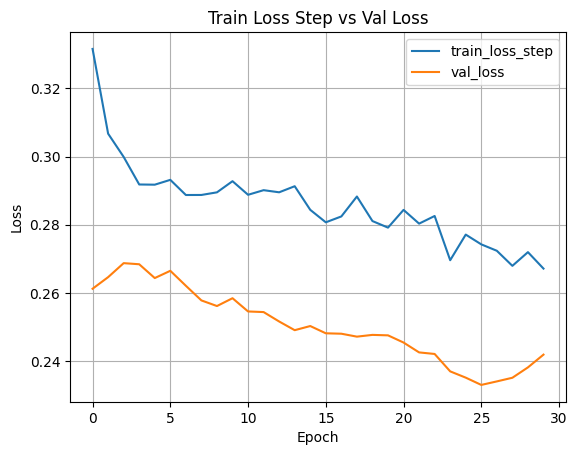


📊 Hyperparameters for version_7:
learning_rate            : 2.5e-05
dropout                  : 0.25
hidden_size              : 64
hidden_continuous_size   : 32
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_7...


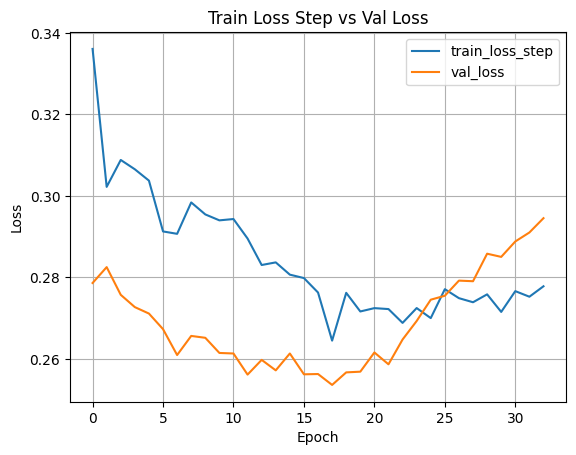


📊 Hyperparameters for version_9:
learning_rate            : 2.5e-05
dropout                  : 0.25
hidden_size              : 32
hidden_continuous_size   : 29
attention_head_size      : 3
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_9...


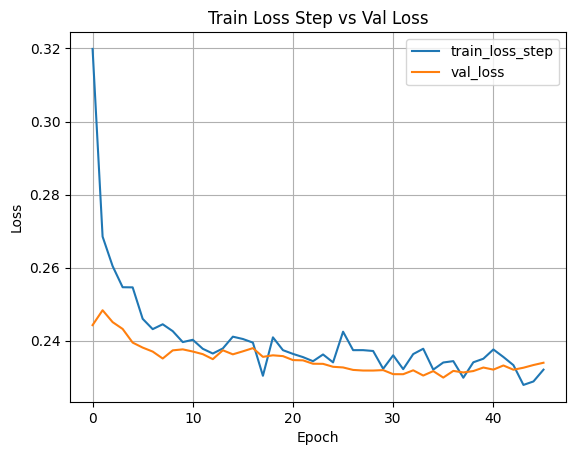


📊 Hyperparameters for version_11:
learning_rate            : 5.0e-05
dropout                  : 0.25
hidden_size              : 63
hidden_continuous_size   : 31
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_11...


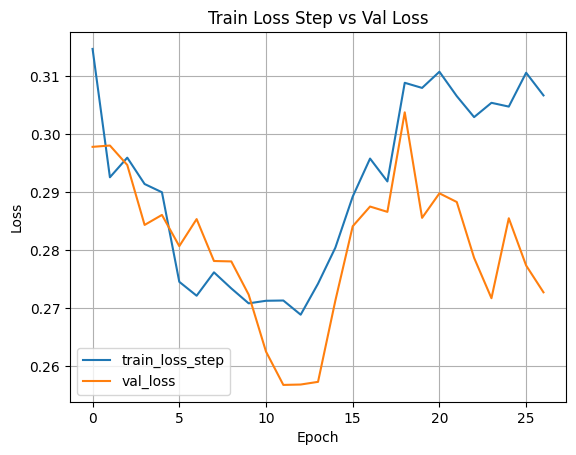


📊 Hyperparameters for version_13:
learning_rate            : 2.5e-05
dropout                  : 0.25
hidden_size              : 41
hidden_continuous_size   : 35
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_13...


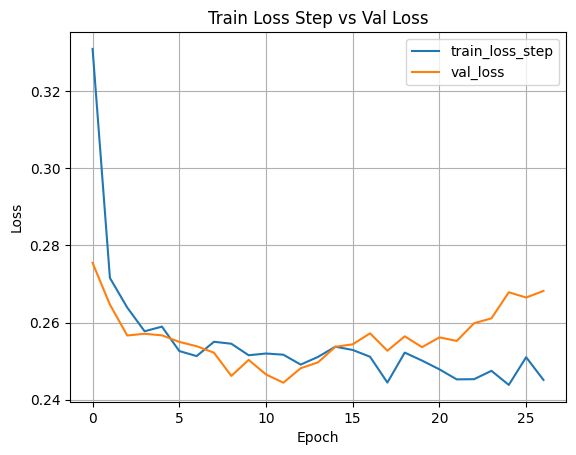


📊 Hyperparameters for version_16:
learning_rate            : 5.0e-05
dropout                  : 0.3
hidden_size              : 71
hidden_continuous_size   : 23
attention_head_size      : 4
lstm_layers              : 1
max_encoder_length       : 200
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 400 (200 encoder + 200 prediction)


Plotting metrics for version_16...


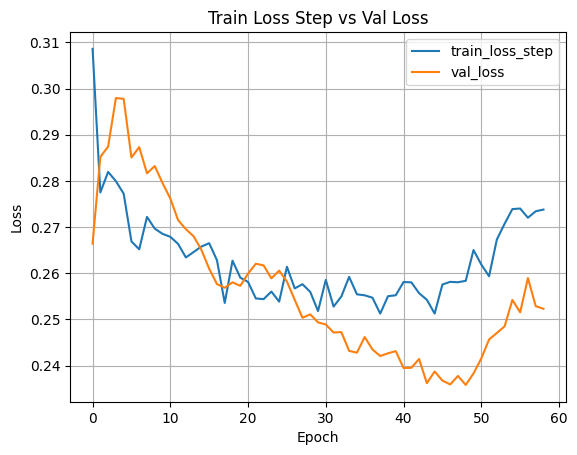


📊 Hyperparameters for version_18:
learning_rate            : 4.0e-05
dropout                  : 0.25
hidden_size              : 45
hidden_continuous_size   : 37
attention_head_size      : 3
lstm_layers              : 1
max_encoder_length       : 400
max_prediction_length    : 200
min_encoder_length       : 1
weight_decay             : 0.0005
causal_attention         : True
optimizer                : adam
reduce_on_plateau_patience: 4
reduce_on_plateau_min_lr : 1.0e-05
reduce_on_plateau_reduction: 2.0
predict_mode             : False
Total Sequence Length    : 600 (400 encoder + 200 prediction)


Plotting metrics for version_18...


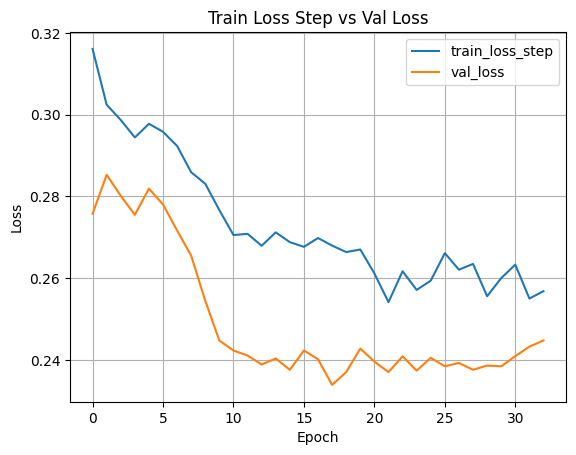

In [20]:
import os
import importlib
# reload utils.viz to ensure latest changes are used
import utils.viz
importlib.reload(utils.viz)
from utils.viz import plot_metrics, extract_hparams

# Plot training and validation loss and extract hyperparameters
logs_dir = "./logs/tft_model/"
for version in ['version_5', 'version_7', 'version_9', 'version_11', 'version_13', 'version_16', 'version_18']:
    version_path = os.path.join(logs_dir, version)
    if not os.path.isdir(version_path):
        continue
    metrics_file = os.path.join(version_path, "metrics.csv")
    hparams_file = os.path.join(version_path, "hparams.yaml")
    
    # Extract and display hyperparameters (if they exist)
    if os.path.exists(hparams_file):
        print(f"\n📊 Hyperparameters for {version}:")
        print("=" * 50)
        
        try:
            params = extract_hparams(hparams_file)
            
            # Define the parameters we're interested in
            key_params = [
                'learning_rate',
                'dropout',
                'hidden_size',
                'hidden_continuous_size',
                'attention_head_size',
                'lstm_layers',
                'max_encoder_length',
                'max_prediction_length',
                'min_encoder_length',
                'weight_decay',
                'causal_attention',
                'optimizer',
                'reduce_on_plateau_patience',
                'reduce_on_plateau_min_lr',
                'reduce_on_plateau_reduction',
                'randomize_length',
                'predict_mode',
            ]
            
            # Display found parameters
            for param in key_params:
                if param in params:
                    print(f"{param:25}: {params[param]}")
            
            # Calculate and display total sequence length
            encoder_len = params.get('max_encoder_length', 'N/A')
            pred_len = params.get('max_prediction_length', 'N/A')
            if isinstance(encoder_len, int) and isinstance(pred_len, int):
                total_len = encoder_len + pred_len
                print(f"{'Total Sequence Length':25}: {total_len} ({encoder_len} encoder + {pred_len} prediction)")
            
            # Display target variables
            if 'target_variables' in params:
                print(f"{'target_variables':25}: {', '.join(params['target_variables'])}")
            
        except Exception as e:
            print(f"Error processing {hparams_file}: {str(e)}")
        
        print("\n" + "=" * 50 + "\n")

    if os.path.exists(metrics_file):
        print(f"Plotting metrics for {version}...")
        plot_metrics(
            metrics_file,
            plot_metrics=[["train_loss_step", "val_loss"]],
            # save_svg_path=os.path.join("./assets/", f"loss_plot_{version}.svg")
        )

## Overfitting Analysis

One of the main objectives was to reduce overfitting while preserving the model’s predictive capability. Analysis of metrics from initial training runs revealed clear signs of overfitting. Several potential causes were identified:

### Dataset Size and Diversity vs. Model Complexity

The primary issue was the limited number of samples, driven by two factors: (1) filtering for relatively long training sessions capable of capturing endurance-related physiological patterns, and (2) intentionally restricting dataset size to accelerate training. At the same time, the model was configured to process long sequence lengths to capture dependencies over larger time windows. However, this increased the number of trainable parameters, making the model overly complex relative to the available data.

Another issue is that many sessions were conducted under varying conditions unknown to the model, including:
- No distinction between training and competition sessions. The Rate of Perceived Exertion (RPE) differs significantly: long training sessions typically maintain an RPE of 3–4, with brief intervals at RPE 5–8, whereas competitions predominantly operate at RPE 5–8, with recovery periods at RPE 2–4.  
- Lack of information on caloric intake, hydration, or ergogenic aids, all of which can significantly impact athletic performance.

A future improvement will involve expanding the dataset with more samples and enriching it with additional metadata such as RPE labels.

### Data Imbalance

An initial configuration used `predict=True` in `TimeSeriesDataSet.from_dataset()` for the validation set, which generated only **one sample per session** for validation. While this initially seemed reasonable, given that the data split was session-based, it created a significant imbalance when compared to the much larger number of training samples produced by the training dataloader. After reviewing the library documentation (https://pytorch-forecasting.readthedocs.io/en/v1.4.0/api/pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.html#pytorch_forecasting.data.timeseries._timeseries.TimeSeriesDataSet.from_dataset), it became clear that this parameter controls whether only the final sequence per series is used (`predict=True`) or multiple subsequences are generated (`predict=False`). The setting was changed to `predict=False` to obtain multiple validation samples per session, ensuring a more balanced evaluation.

### Excessively Long Sequences

The model was initially configured with an encoder length of 250 steps plus a prediction horizon of 50 steps (300 total steps), aiming to capture long-range temporal dependencies relevant to endurance activities. However, this made the model too complex for the dataset size. Various encoder/prediction length combinations were tested without significant improvement. Ultimately, the configuration was reduced to an encoder length of 200 steps and a prediction horizon of 40 steps (240 total steps).

### Insufficient Regularization

Initially, sequence lengths were not randomized, dropout was low (0.1), and `weight_decay` was not enabled for regularization. To address this, `randomize_length=True` was activated, dropout was increased to 0.3, and `weight_decay` was added to the optimizer.

### Complex Multi-Target Prediction

The model simultaneously predicts 5 target variables using 21 input features. To handle the varying scales and importance of these targets, a weighted loss function was implemented as a solution.

## Evaluación

In [22]:
import torch
import numpy as np
import lightning.pytorch as pl
from lightning.pytorch.loggers import CSVLogger
from training import find_latest_checkpoint
from lib.model import TrailRunningTFT
from lib.data import TFTDataModule

# Create and setup the TFT data module
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=1,
    max_encoder_length=400,
    max_prediction_length=200,
    batch_size=64,
    num_workers=2,
)

# Setup the data
data_module.setup()

# Evaluate the model
logger = CSVLogger(
    save_dir="./logs/tft_model/",
    name="tft_evaluation",
    version=0
)

# Load the trainer on the latest checkpoint
trainer = pl.Trainer(
    max_epochs=1,
    accelerator='auto',
    strategy='auto',
    logger=logger,
    devices='auto',
    enable_checkpointing=True,
    precision="32-true",
    callbacks=[]
)

model = TrailRunningTFT.from_dataset(
    data_module.test,
    hidden_size=45,
    learning_rate=0.001,
    output_size=[1] * 4, # Multi-target output 
)

ckpt_path = find_latest_checkpoint()
if (not ckpt_path):
    print("No checkpoint found, cannot evaluate model.")
    exit(1)

print(f"Cargando modelo desde checkpoint: {ckpt_path}")

# Test the model on test dataset
test_results = trainer.test(model, data_module.test_dataloader(), ckpt_path=ckpt_path)


Loading 101 training session files...


Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']


INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

Training samples: 352205
Validation samples: 77647
Test samples: 11
Initialized MultiLoss with target weights:
  duration_diff: 85.0%
  heartRate: 5.0%
  temperature: 5.0%
  cadence: 5.0%


INFO: Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt


Cargando modelo desde checkpoint: ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO: Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at ./checkpoints/best-checkpoint-epoch=17-val_loss=0.23.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     cadence test_MAE      │    4.2775397300720215     │
│     cadence test_RMSE     │     6.30612850189209      │
│    cadence test_SMAPE     │    0.05505767837166786    │
│  duration_diff test_MAE   │    0.6291716694831848     │
│  duration_diff test_RMSE  │    0.9269328117370605     │
│ duration_diff test_SMAPE  │    0.4518342614173889     │
│    heartRate test_MAE     │    18.682706832885742     │
│    heartRate test_RMSE    │       20.6123046875       │
│   heartRate test_SMAPE    │    0.13618212938308716    │
│   temperature test_MAE    │     4.840836048126221     │
│   temperature test_RMSE   │     5.212912559509277     │
│  temperature test_SMAPE   │    0.2872926592826843     │
│         test_loss         │    0.40798577666282654    │
└───────────────────────────┴───────────────────────────┘

## Single Batch Sample Visualization

INFO: Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:lightning.pytorch.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheck

tensor([400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400])
=== Visualizing Duration (Target 0) for Batch 0 ===


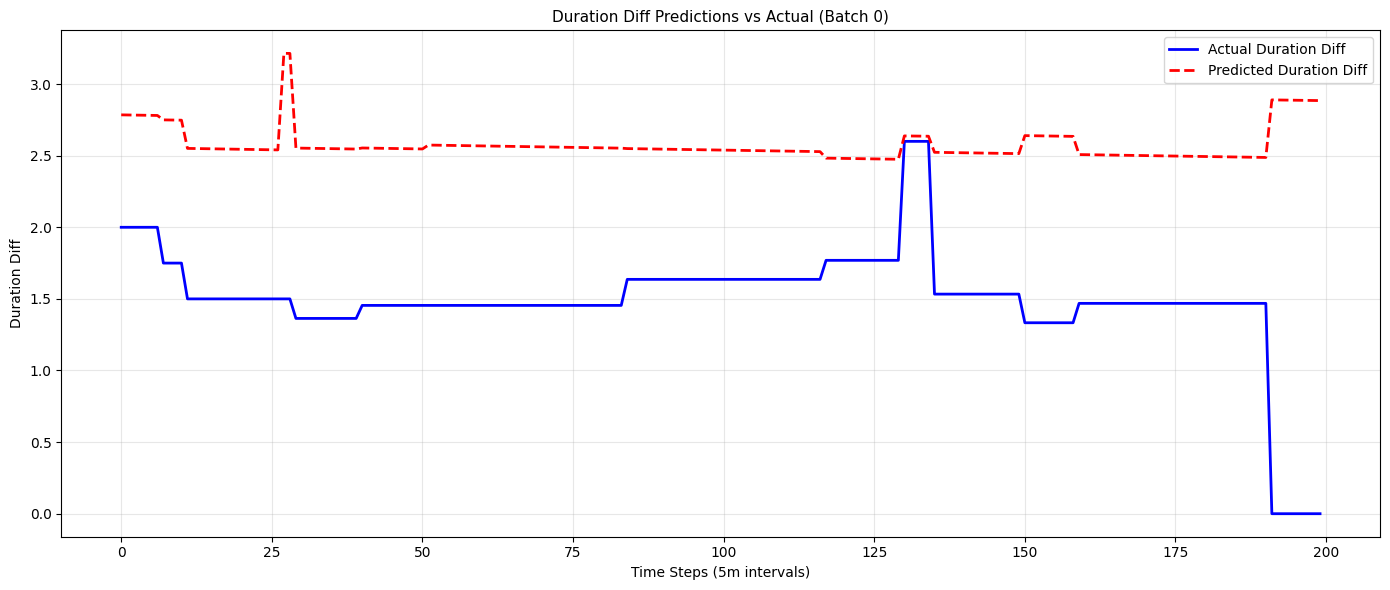


Error Metrics for Duration Diff (Batch 0)
Session ID (encoded): 75

MSE:  1.3656
MAE:  1.0797
RMSE: 1.1686
MAPE: 65.87%


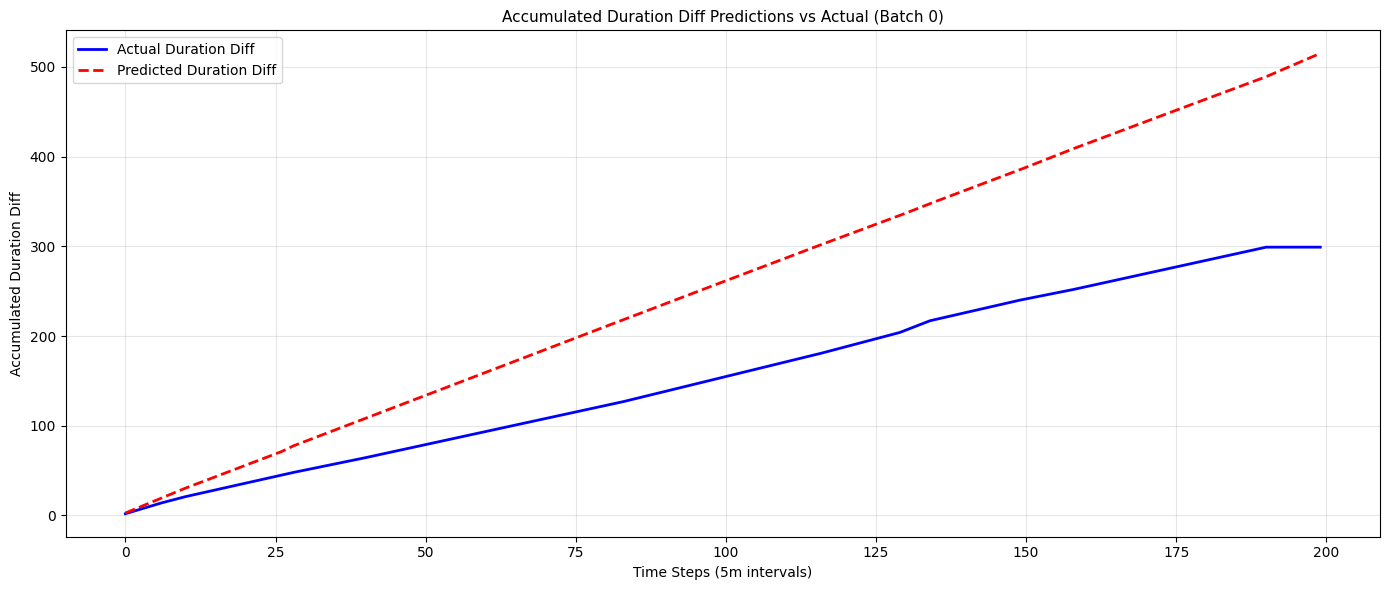


Error Metrics for Duration Diff (Batch 0)
Session ID (encoded): 75

MSE:  1.3656
MAE:  1.0797
RMSE: 1.1686
MAPE: 65.87%

Accumulated Totals:
Actual Total: 299.00
Predicted Total: 514.95
Absolute Difference: 215.95
Percentage Difference: 72.22%

=== Visualizing Heart Rate (Target 1) for Batch 0 ===


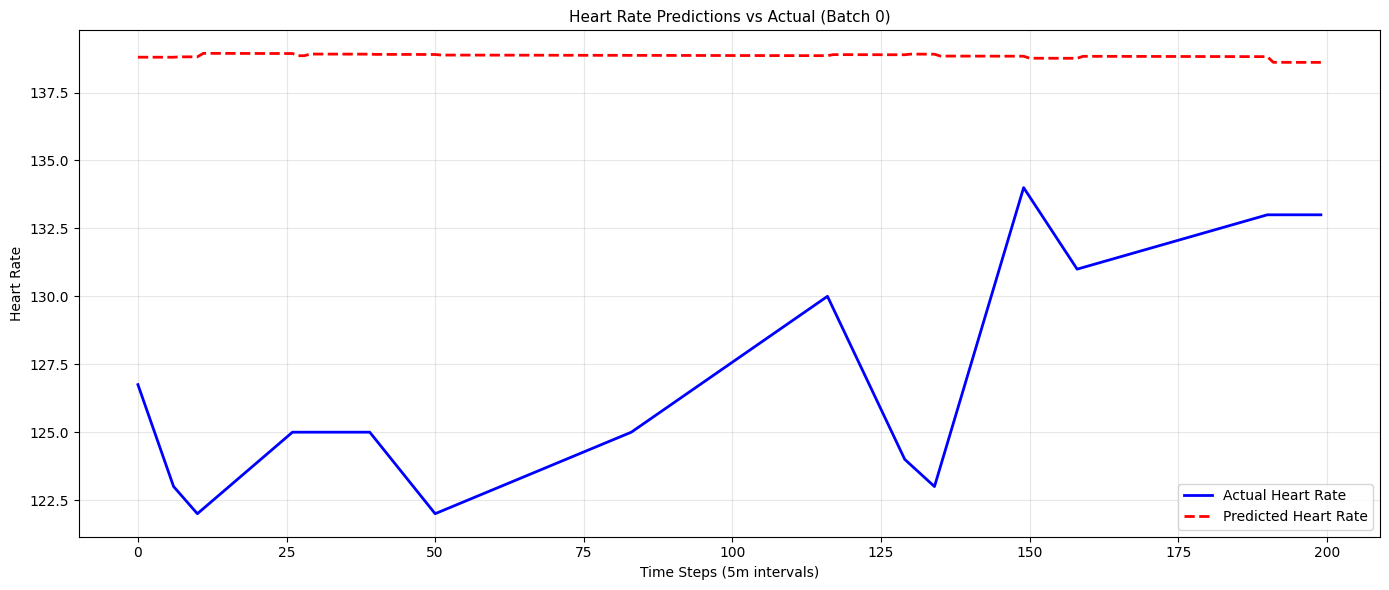


Error Metrics for Heart Rate (Batch 0)
Session ID (encoded): 75

MSE:  152.0129
MAE:  11.7462
RMSE: 12.3294
MAPE: 9.33%

=== Visualizing Duration (Target 0) for Batch 1 ===


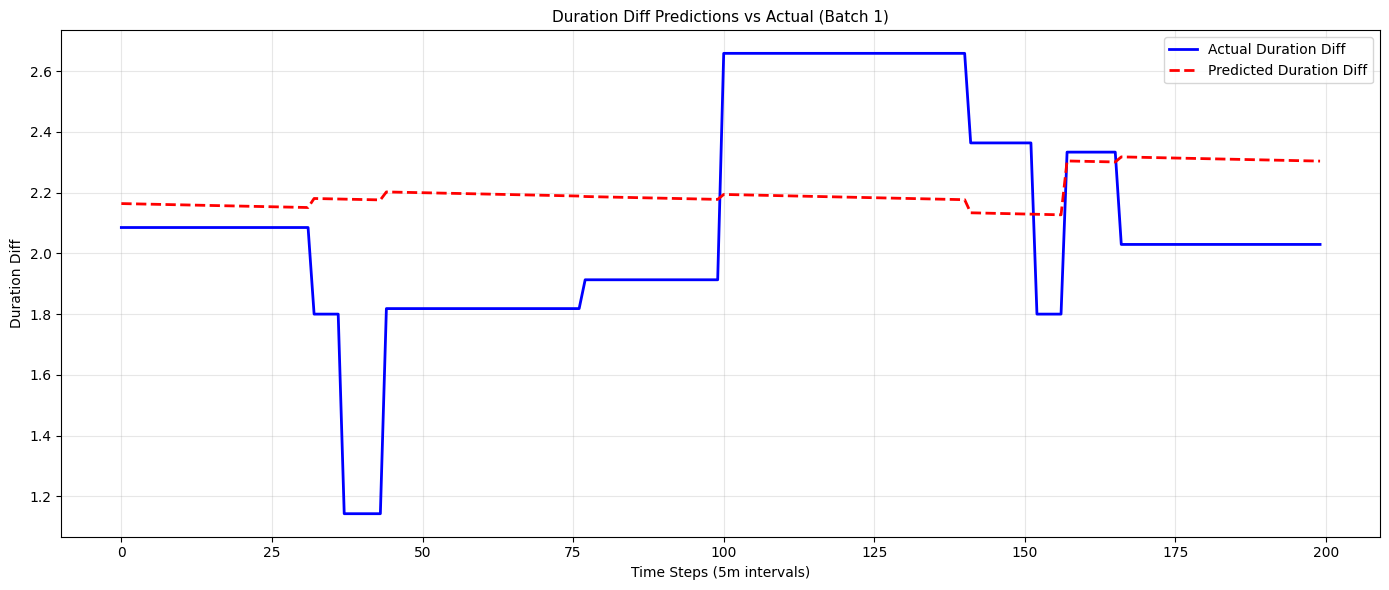


Error Metrics for Duration Diff (Batch 1)

MSE:  0.1388
MAE:  0.3177
RMSE: 0.3726
MAPE: 16.35%


In [43]:
import importlib
import utils.viz
importlib.reload(utils.viz)
from utils.viz import visualize_predictions

raw_predictions = model.predict(
    data_module.test_dataloader(), mode="raw", return_x=True
)
# print(raw_predictions.x.keys())
print(raw_predictions.x['encoder_lengths'])

# Visualize duration for batch 0
print("=== Visualizing Duration (Target 0) for Batch 0 ===")
pred_duration, act_duration = visualize_predictions(raw_predictions, batch_id=0, target_idx=0, target_name="Duration Diff")
pred_duration, act_duration = visualize_predictions(raw_predictions, batch_id=0, target_idx=0, target_name="Duration Diff", show_accumulated=True)

# Visualize heart rate for batch 0
print("\n=== Visualizing Heart Rate (Target 1) for Batch 0 ===")
pred_hr, act_hr = visualize_predictions(raw_predictions, batch_id=0, target_idx=1, target_name="Heart Rate")

# If you have multiple batches, visualize a different batch
print("\n=== Visualizing Duration (Target 0) for Batch 1 ===")
try:
    pred_duration_b1, act_duration_b1 = visualize_predictions(raw_predictions, batch_id=1, target_idx=0, target_name="Duration Diff")
except IndexError:
    print("Batch 1 not available (only 1 batch in dataset)")

## Full cold-start inference for an entire session

Performs sequential cold-start inference on the first test session:
1. Uses synthetic encoder (weighted avg of historical first samples) with encoder_length=1
2. Predicts max_prediction_length (200) steps using known terrain data
3. Uses predicted values to create encoder for next chunk
4. Repeats until entire session is predicted
5. Visualizes accumulated duration error throughout

In [38]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Reload modules for latest changes
import importlib
import lib.data
import lib.model
importlib.reload(lib.data)
importlib.reload(lib.model)
from lib.data import TFTDataModule, calculate_weighted_first_sample
from lib.model import TrailRunningTFT
from training import find_latest_checkpoint

# =============================================================================
# CONFIGURATION
# =============================================================================
ENCODER_LENGTH = 1  # Cold-start: minimal encoder
MAX_PREDICTION_LENGTH = 200  # Steps to predict per chunk
MAX_ENCODER_LENGTH = 400  # For dataset configuration

print("="*80)
print("COLD-START SEQUENTIAL INFERENCE")
print("="*80)
print(f"Encoder Length: {ENCODER_LENGTH}")
print(f"Prediction Length per chunk: {MAX_PREDICTION_LENGTH}")
print("="*80)

# =============================================================================
# SETUP DATA MODULE AND MODEL
# =============================================================================
# Create data module (without sliding windows for raw data access)
data_module = TFTDataModule(
    data_dir="./data/resampled",
    min_encoder_length=ENCODER_LENGTH,
    max_encoder_length=MAX_ENCODER_LENGTH,
    max_prediction_length=MAX_PREDICTION_LENGTH,
    batch_size=1,  # Single sample for inference
    num_workers=0,
    use_sliding_windows=False
)
data_module.setup()

# Load checkpoint
ckpt_path = find_latest_checkpoint()
if not ckpt_path:
    raise RuntimeError("No checkpoint found!")
print(f"\nLoading model from: {ckpt_path}")

# Load model - use CPU for inference to avoid device issues
model = TrailRunningTFT.load_from_checkpoint(ckpt_path, map_location='cpu')
model.eval()


COLD-START SEQUENTIAL INFERENCE
Encoder Length: 1
Prediction Length per chunk: 200
Loading 101 training session files...
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known 

TrailRunningTFT(
  	"attention_head_size":               3
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'time_idx', 'target': ['duration_diff', 'heartRate', 'temperature', 'cadence'], 'group_ids': ['session_id_encoded'], 'weight': None, 'max_encoder_length': 400, 'min_encoder_length': 1, 'min_prediction_idx': 0, 'min_prediction_length': 200, 'max_prediction_length': 200, 'static_categoricals': None, 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': False, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'a

In [55]:
test_session_ids = sorted(data_module.test_data['session_id'].unique())
for session_id in test_session_ids:
    session_length = len(data_module.test_data[data_module.test_data['session_id'] == session_id])
    distance_km = session_length * 5 / 1000  # 5m per step
    print(f"{session_id}: {session_length} steps ({distance_km:.2f} km)")

training-session-2025-02-25-8061276512-5f1e505e-faa9-446e-baca-0af78f90e6b7: 3470 steps (17.35 km)
training-session-2025-03-01-8063894910-3798d23c-94c2-464d-b8b0-05a092cb6652: 3715 steps (18.57 km)
training-session-2025-03-07-8067673091-6f8df649-a05e-486b-a405-7cfac373eea9: 3627 steps (18.14 km)
training-session-2025-03-09-8069229866-675a6a83-bd23-46ca-855a-58106d60ad86: 2899 steps (14.49 km)
training-session-2025-03-13-8071682142-0e6800df-ffe8-4344-a399-0e36467f6d6b: 3414 steps (17.07 km)
training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1: 4903 steps (24.52 km)
training-session-2025-03-23-8078233046-62fbec09-969b-4960-b3c0-93a55c17f778: 4475 steps (22.38 km)
training-session-2025-03-28-8083709660-dcd72912-9628-4fbe-82d1-12ec7796237a: 3388 steps (16.94 km)
training-session-2025-04-05-8090858642-183e3db9-8a48-4849-a88a-e79f8db3356d: 3915 steps (19.57 km)
training-session-2025-04-17-8097527167-c71fd6ff-9718-47a2-a948-7ed5eb38990c: 4071 steps (20.36 km)
training-s

In [56]:

# =============================================================================
# GET FIRST TEST SESSION
# =============================================================================
test_session_ids = sorted(data_module.test_data['session_id'].unique())
session_id = test_session_ids[5]
first_test_session_encoded = data_module.test_data[
    data_module.test_data['session_id'] == session_id
]['session_id_encoded'].iloc[0]

print(f"\nTest sessions available: {len(test_session_ids)}")
print(f"First test session: {session_id}")
print(f"Session ID encoded: {first_test_session_encoded}")

# Get full session data
session_data = data_module.test_data[
    data_module.test_data['session_id'] == session_id
].copy().reset_index(drop=True)
session_length = len(session_data)
print(f"Session length: {session_length} steps ({session_length * 5 / 1000:.2f} km)")

# Get synthetic encoder from training data
synthetic_encoder = calculate_weighted_first_sample(data_module.train_data)

# Override with actual known values from target session's first step
known_future_vars = ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss', 'distance']
for var in known_future_vars:
    if var in session_data.columns:
        synthetic_encoder[var] = session_data.iloc[0][var]

print("\nSynthetic Encoder Created (Cold-Start Initial Values):")
print(f"  Heart Rate: {synthetic_encoder.get('heartRate', 'N/A'):.1f}")
print(f"  Temperature: {synthetic_encoder.get('temperature', 'N/A'):.1f}")
print(f"  Cadence: {synthetic_encoder.get('cadence', 'N/A'):.1f}")
print(f"  Speed: {synthetic_encoder.get('speed', 'N/A'):.2f}")

# =============================================================================
# SEQUENTIAL PREDICTION LOOP
# =============================================================================
all_predictions = {
    'duration_diff': [],
    'heartRate': [],
    'temperature': [],
    'cadence': []
}
all_actuals = {
    'duration_diff': [],
    'heartRate': [],
    'temperature': [],
    'cadence': []
}
chunk_boundaries = []
chunk_errors = []

target_names = ['duration_diff', 'heartRate', 'temperature', 'cadence']
chunk_idx = 0
start_idx = 0

# Track accumulated predicted values for encoder creation
accumulated_predictions = {name: [] for name in target_names}

print("\n" + "="*80)
print("STARTING SEQUENTIAL PREDICTION")
print("="*80)

while start_idx < session_length:
    chunk_idx += 1
    
    # Calculate chunk boundaries
    pred_start = start_idx
    pred_end = min(start_idx + MAX_PREDICTION_LENGTH, session_length)
    pred_length = pred_end - pred_start
    
    if pred_length < 10:  # Skip very small chunks
        break
    
    print(f"\n--- Chunk {chunk_idx} ---")
    print(f"  Prediction range: steps {pred_start} to {pred_end-1} ({pred_length} steps)")
    print(f"  Distance: {session_data.iloc[pred_start]['distance']/1000:.2f} km to {session_data.iloc[pred_end-1]['distance']/1000:.2f} km")
    
    # Create inference data for this chunk
    if chunk_idx == 1:
        # Cold-start: create synthetic encoder row + actual prediction data
        encoder_df = pd.DataFrame([synthetic_encoder])
        encoder_df['time_idx'] = 0
        encoder_df['session_id_encoded'] = int(first_test_session_encoded)
        encoder_df['session_id'] = session_id
        
        # Get prediction portion from actual session data
        pred_df = session_data.iloc[pred_start:pred_end].copy()
        pred_df['time_idx'] = range(1, pred_length + 1)
        
        # Combine encoder + prediction data
        chunk_data = pd.concat([encoder_df, pred_df], ignore_index=True)
    else:
        # Use previous predictions as encoder + new prediction data
        # Get the last few steps from session data and replace targets with predictions
        encoder_steps = min(ENCODER_LENGTH, pred_start)
        encoder_start = max(0, pred_start - encoder_steps)
        
        # Create chunk with encoder + prediction portion
        chunk_data = session_data.iloc[encoder_start:pred_end].copy()
        chunk_data = chunk_data.reset_index(drop=True)
        chunk_data['time_idx'] = range(len(chunk_data))
        
        # Replace encoder portion targets with accumulated predictions
        if len(accumulated_predictions['duration_diff']) >= encoder_steps:
            for i in range(encoder_steps):
                global_pred_idx = pred_start - encoder_steps + i
                for target in target_names:
                    if global_pred_idx < len(accumulated_predictions[target]):
                        chunk_data.loc[i, target] = accumulated_predictions[target][global_pred_idx]
    
    # Ensure consistent types
    chunk_data['session_id_encoded'] = chunk_data['session_id_encoded'].astype(int)
    chunk_data['time_idx'] = chunk_data['time_idx'].astype(int)
    
    # Create TimeSeriesDataSet for this chunk
    time_varying_known_reals = ["altitude", "elevation_diff", "elevation_gain", "elevation_loss"]
    time_varying_unknown_reals = target_names + ["speed", "avg_heart_rate_so_far", "duration"]
    
    # Determine actual encoder and prediction lengths
    actual_encoder_len = 1 if chunk_idx == 1 else min(ENCODER_LENGTH, pred_start)
    actual_pred_len = pred_length
    
    try:
        chunk_dataset = TimeSeriesDataSet(
            chunk_data,
            time_idx="time_idx",
            target=target_names,
            group_ids=["session_id_encoded"],
            min_encoder_length=1,
            max_encoder_length=max(1, actual_encoder_len),
            min_prediction_length=actual_pred_len,
            max_prediction_length=actual_pred_len,
            time_varying_known_reals=time_varying_known_reals,
            time_varying_unknown_reals=time_varying_unknown_reals,
            target_normalizer=MultiNormalizer(
                [GroupNormalizer(groups=["session_id_encoded"], transformation=None) for _ in target_names]
            ),
            add_relative_time_idx=True,
            add_target_scales=True,
            categorical_encoders={"session_id_encoded": NaNLabelEncoder(add_nan=True)},
            add_encoder_length=True,
            predict_mode=True
        )
        
        # Create dataloader and get batch
        chunk_loader = chunk_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
        batch = next(iter(chunk_loader))
        
        # Make prediction
        x, y = batch
        
        with torch.no_grad():
            output = model(x)
        
        # Extract predictions
        predictions = output['prediction']
        
        # Store predictions and actuals
        for i, target in enumerate(target_names):
            if isinstance(predictions, list):
                pred_vals = predictions[i][0, :, 0].cpu().numpy()
            else:
                pred_vals = predictions[0, :, i].cpu().numpy()
            
            # Get actual values
            actual_vals = session_data.iloc[pred_start:pred_start + len(pred_vals)][target].values
            
            # Ensure same length
            min_len = min(len(pred_vals), len(actual_vals))
            pred_vals = pred_vals[:min_len]
            actual_vals = actual_vals[:min_len]
            
            all_predictions[target].extend(pred_vals)
            all_actuals[target].extend(actual_vals)
            accumulated_predictions[target].extend(pred_vals)
        
        # Calculate chunk error for duration_diff
        pred_duration = np.array(all_predictions['duration_diff'][-min_len:])
        actual_duration = np.array(all_actuals['duration_diff'][-min_len:])
        chunk_mae = np.mean(np.abs(pred_duration - actual_duration))
        chunk_errors.append({
            'chunk': chunk_idx,
            'start_idx': pred_start,
            'end_idx': pred_start + min_len,
            'mae': chunk_mae,
            'accumulated_pred': np.sum(all_predictions['duration_diff']),
            'accumulated_actual': np.sum(all_actuals['duration_diff'])
        })
        
        chunk_boundaries.append(pred_start)
        
        print(f"  Predictions obtained: {min_len} steps")
        print(f"  Chunk MAE (duration_diff): {chunk_mae:.4f}")
        
    except Exception as e:
        print(f"  Error in chunk {chunk_idx}: {str(e)}")
        import traceback
        traceback.print_exc()
        break
    
    # Move to next chunk
    start_idx = pred_end

print("\n" + "="*80)
print("PREDICTION COMPLETE")
print("="*80)
print(f"Total chunks processed: {len(chunk_errors)}")
print(f"Total steps predicted: {len(all_predictions['duration_diff'])}")



Test sessions available: 11
First test session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Session ID encoded: 8073715633
Session length: 4903 steps (24.52 km)

Synthetic Encoder Created (Cold-Start Initial Values):
  Heart Rate: 95.2
  Temperature: 22.0
  Cadence: 19.3
  Speed: 2.09

STARTING SEQUENTIAL PREDICTION

--- Chunk 1 ---
  Prediction range: steps 0 to 199 (200 steps)
  Distance: 0.00 km to 0.99 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 0.5767

--- Chunk 2 ---
  Prediction range: steps 200 to 399 (200 steps)
  Distance: 1.00 km to 2.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 0.3648

--- Chunk 3 ---
  Prediction range: steps 400 to 599 (200 steps)
  Distance: 2.00 km to 3.00 km
  Predictions obtained: 200 steps
  Chunk MAE (duration_diff): 0.5767

--- Chunk 2 ---
  Prediction range: steps 200 to 399 (200 steps)
  Distance: 1.00 km to 2.00 km
  Predictions obtained: 200 steps
  Chunk MAE (durati


Per-Chunk Duration Predictions with Elevation Profile


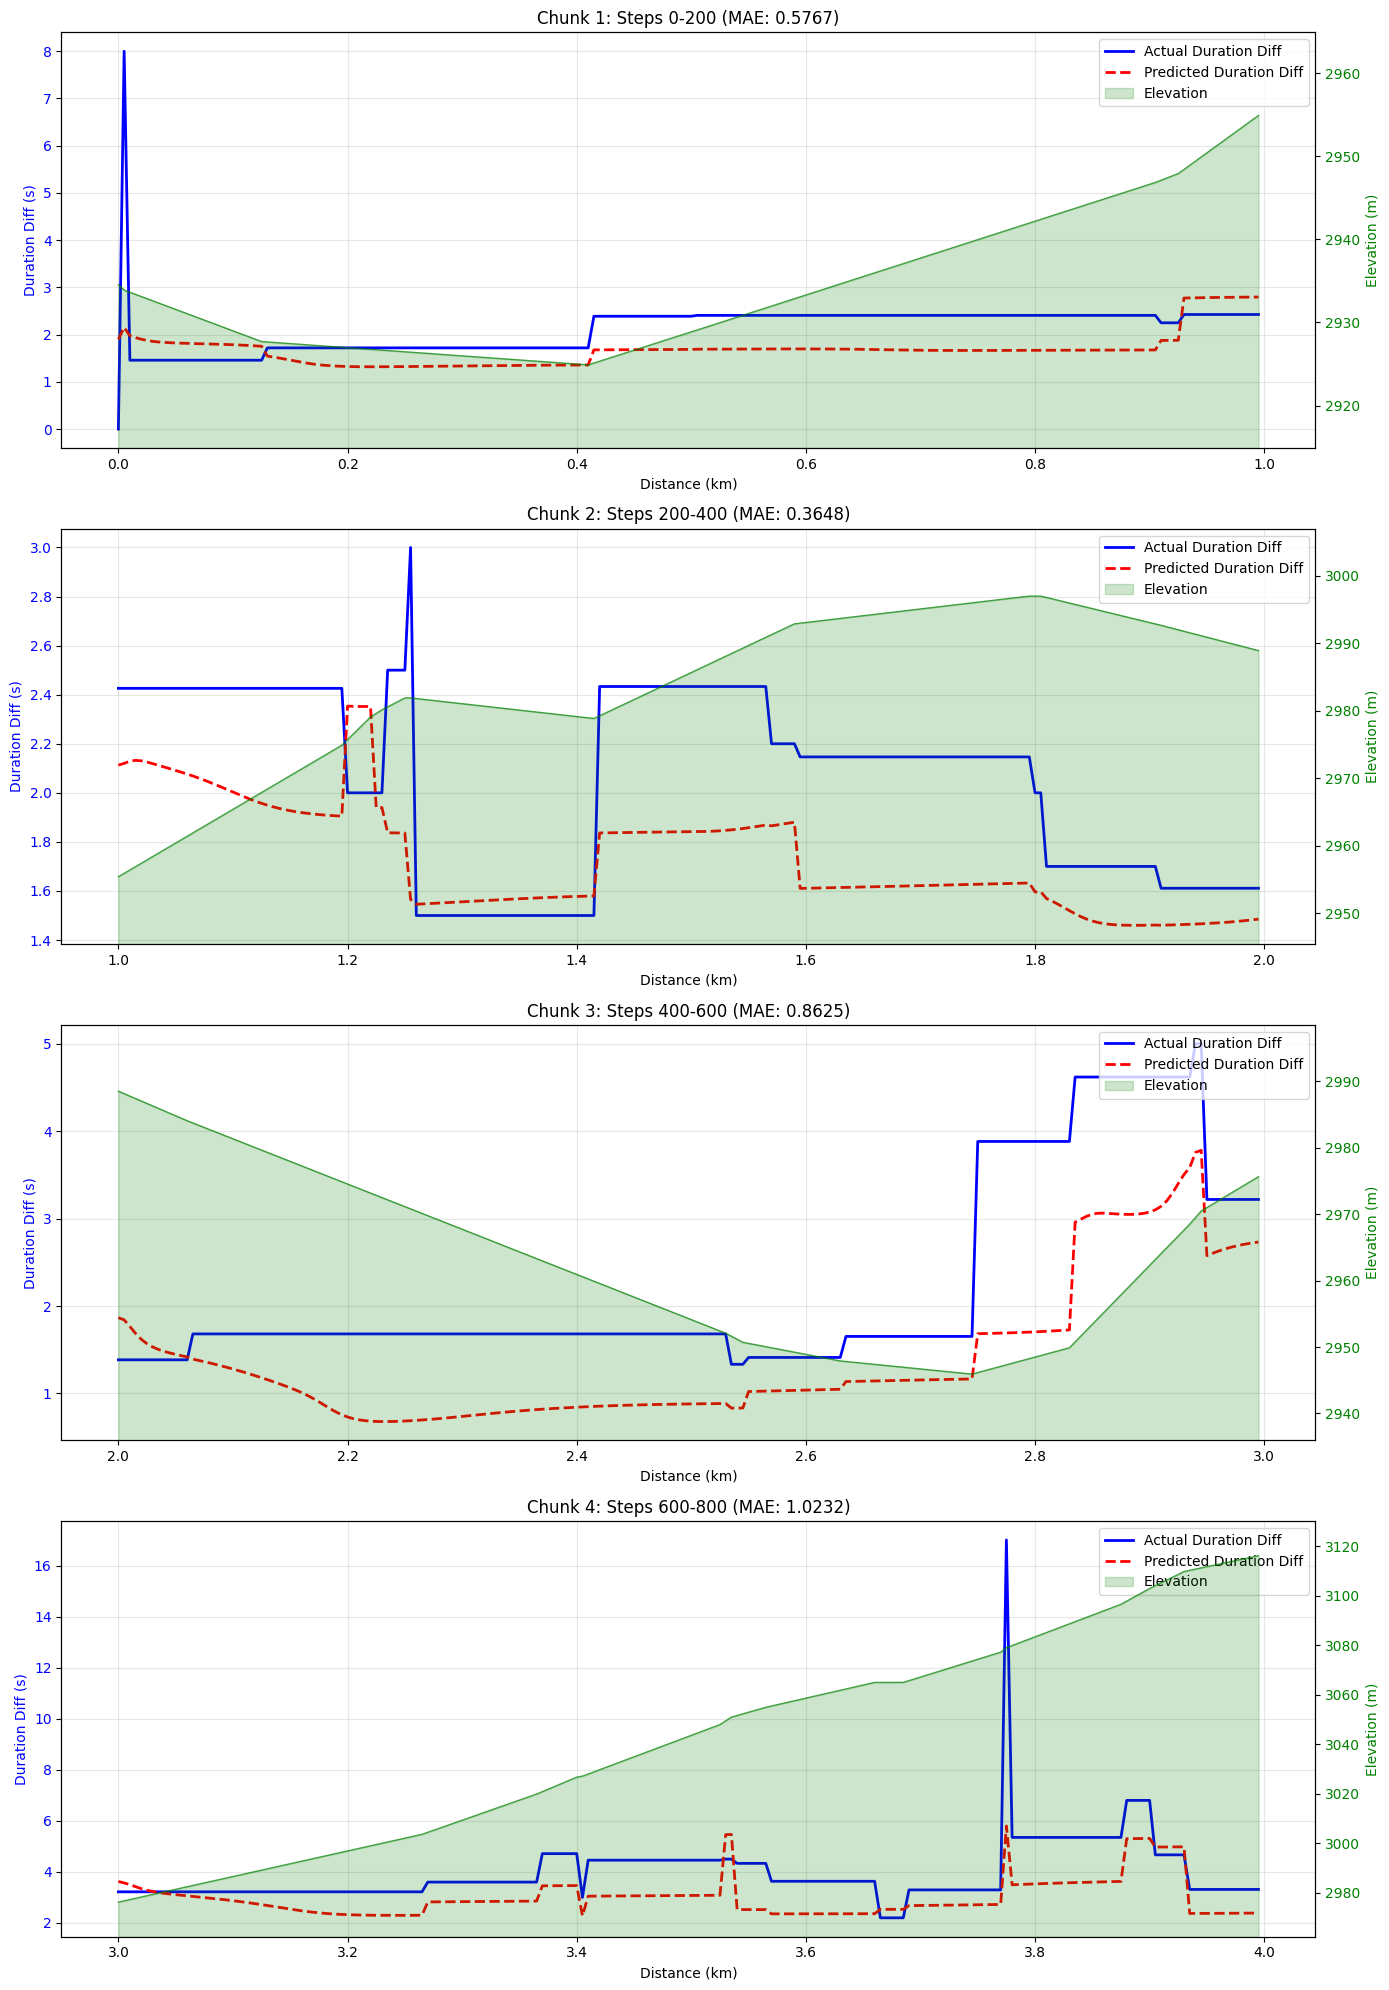


Accumulated Duration Error


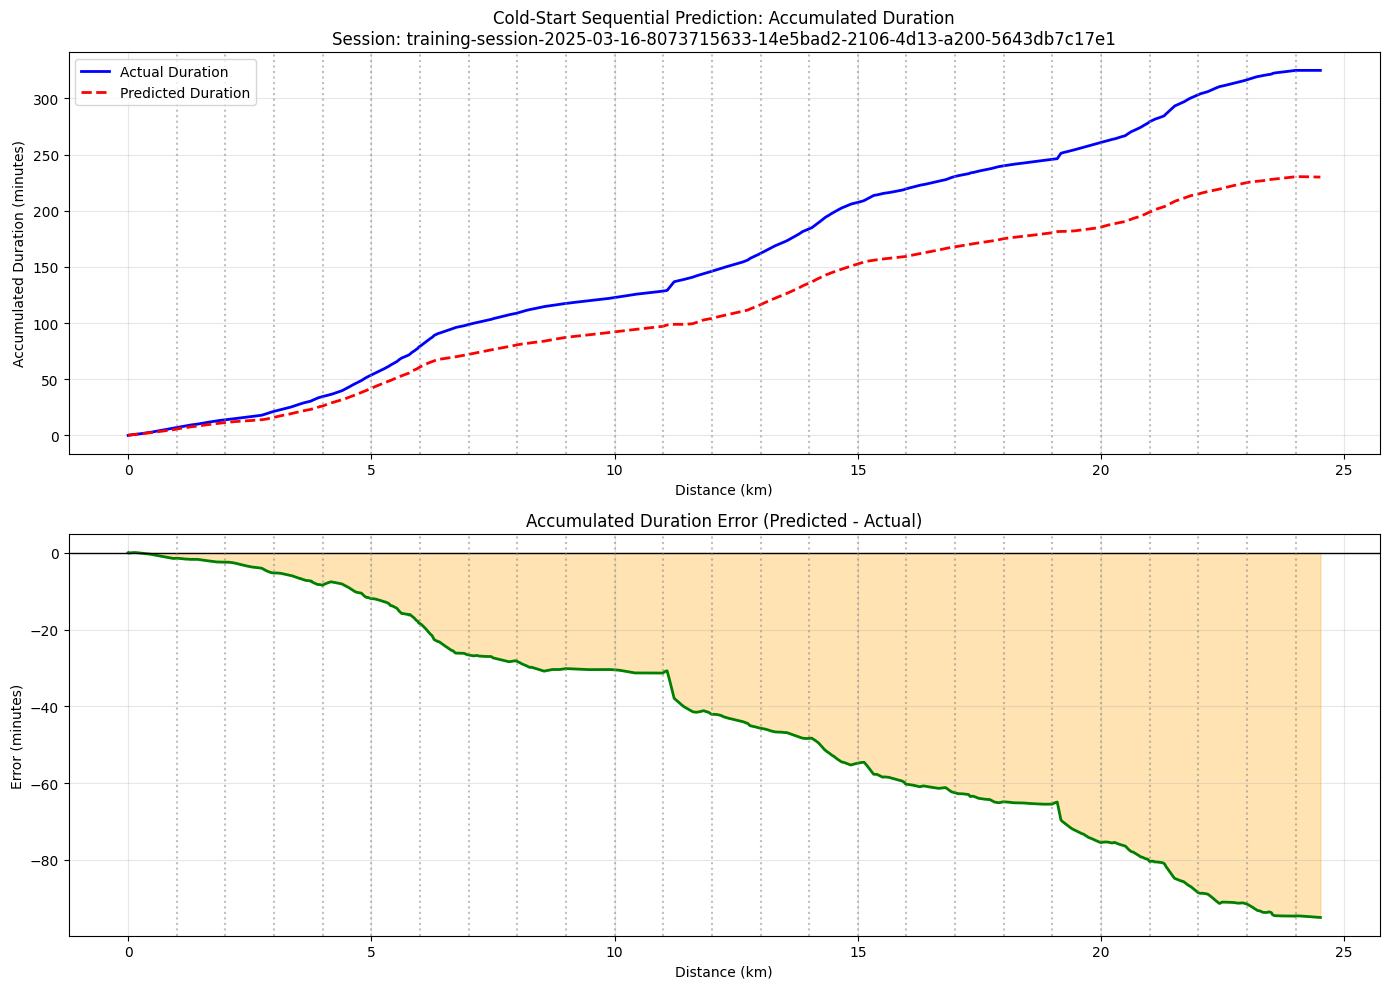


FINAL SUMMARY STATISTICS

Session: training-session-2025-03-16-8073715633-14e5bad2-2106-4d13-a200-5643db7c17e1
Total Distance: 24.51 km
Total Steps Predicted: 4903
Number of Chunks: 25

--- Duration Prediction ---
Actual Total Duration: 324.93 minutes (5.42 hours)
Predicted Total Duration: 229.95 minutes (3.83 hours)
Absolute Error: 94.99 minutes
Percentage Error: 29.23%

--- Per-Chunk MAE (duration_diff) ---
  Chunk 1: MAE = 0.5767
  Chunk 2: MAE = 0.3648
  Chunk 3: MAE = 0.8625
  Chunk 4: MAE = 1.0232
  Chunk 5: MAE = 1.6126
  Chunk 6: MAE = 2.0597
  Chunk 7: MAE = 2.4550
  Chunk 8: MAE = 0.7301
  Chunk 9: MAE = 1.0084
  Chunk 10: MAE = 0.1318
  Chunk 11: MAE = 0.2630
  Chunk 12: MAE = 3.8351
  Chunk 13: MAE = 1.1062
  Chunk 14: MAE = 0.8236
  Chunk 15: MAE = 2.2715
  Chunk 16: MAE = 1.8430
  Chunk 17: MAE = 0.9313
  Chunk 18: MAE = 0.9404
  Chunk 19: MAE = 0.2200
  Chunk 20: MAE = 3.3329
  Chunk 21: MAE = 1.6538
  Chunk 22: MAE = 2.5275
  Chunk 23: MAE = 1.1884
  Chunk 24: MAE = 1.

In [58]:
# =============================================================================
# VISUALIZATION AND SUMMARY
# =============================================================================
import importlib
import utils.viz
import utils.results
importlib.reload(utils.viz)
importlib.reload(utils.results)
from utils.viz import (
    plot_chunk_predictions, 
    plot_accumulated_duration_error
)
from utils.results import (
    print_cold_start_summary,
    save_cold_start_summary
)

if len(chunk_errors) > 0:
    # Plot per-chunk duration predictions
    plot_chunk_predictions(
        all_predictions, all_actuals, chunk_errors, session_data,
        max_chunks=4, save_path='./assets/cold_start_chunks.png'
    )

    # Plot accumulated duration error
    stats = plot_accumulated_duration_error(
        all_predictions, all_actuals, session_data, chunk_boundaries,
        session_id=session_id,
        save_path='./assets/cold_start_accumulated_error.png'
    )

    # Print summary statistics
    summary_stats = print_cold_start_summary(
        all_predictions, chunk_errors, stats, session_id=session_id
    )

    # Save summary to file
    save_cold_start_summary(
        summary_file='./assets/cold_start_inference_summary.md',
        all_predictions=all_predictions,
        chunk_errors=chunk_errors,
        stats=stats,
        summary_stats=summary_stats,
        session_id=session_id,
        encoder_length=ENCODER_LENGTH,
        max_prediction_length=MAX_PREDICTION_LENGTH,
        ckpt_path=ckpt_path
    )
else:
    print("\n⚠️ No successful predictions were made. Check error messages above.")

print("="*80)

### Cold Start Preliminary results analysis

We note that Cold Start predictions are generally lower than the actual values. We need to investigate the training data to find the root cause for this under-prediction on cold start.


OVERALL STATISTICS
Mean Predicted duration_diff: 2.8140 seconds/5m
Mean Actual duration_diff:    3.9763 seconds/5m
Mean Error (Pred - Actual):   -1.1624 seconds/5m
Median Error:                 -0.7191 seconds/5m
Std of Errors:                1.9870

BIAS: -29.23% (negative = under-prediction)

PER-CHUNK BIAS ANALYSIS
------------------------------------------------------------
Chunk  1: Bias = -0.4197s (-19.9%) | Pred mean: 1.690 | Actual mean: 2.110
Chunk  2: Bias = -0.3266s (-15.9%) | Pred mean: 1.729 | Actual mean: 2.055
Chunk  3: Bias = -0.8364s (-37.4%) | Pred mean: 1.400 | Actual mean: 2.236
Chunk  4: Bias = -0.9545s (-24.2%) | Pred mean: 2.990 | Actual mean: 3.944
Chunk  5: Bias = -1.0524s (-18.3%) | Pred mean: 4.707 | Actual mean: 5.759
Chunk  6: Bias = -1.9417s (-25.4%) | Pred mean: 5.703 | Actual mean: 7.645
Chunk  7: Bias = -2.4533s (-41.9%) | Pred mean: 3.399 | Actual mean: 5.852
Chunk  8: Bias = -0.4983s (-16.3%) | Pred mean: 2.558 | Actual mean: 3.056
Chunk  9: Bias = -

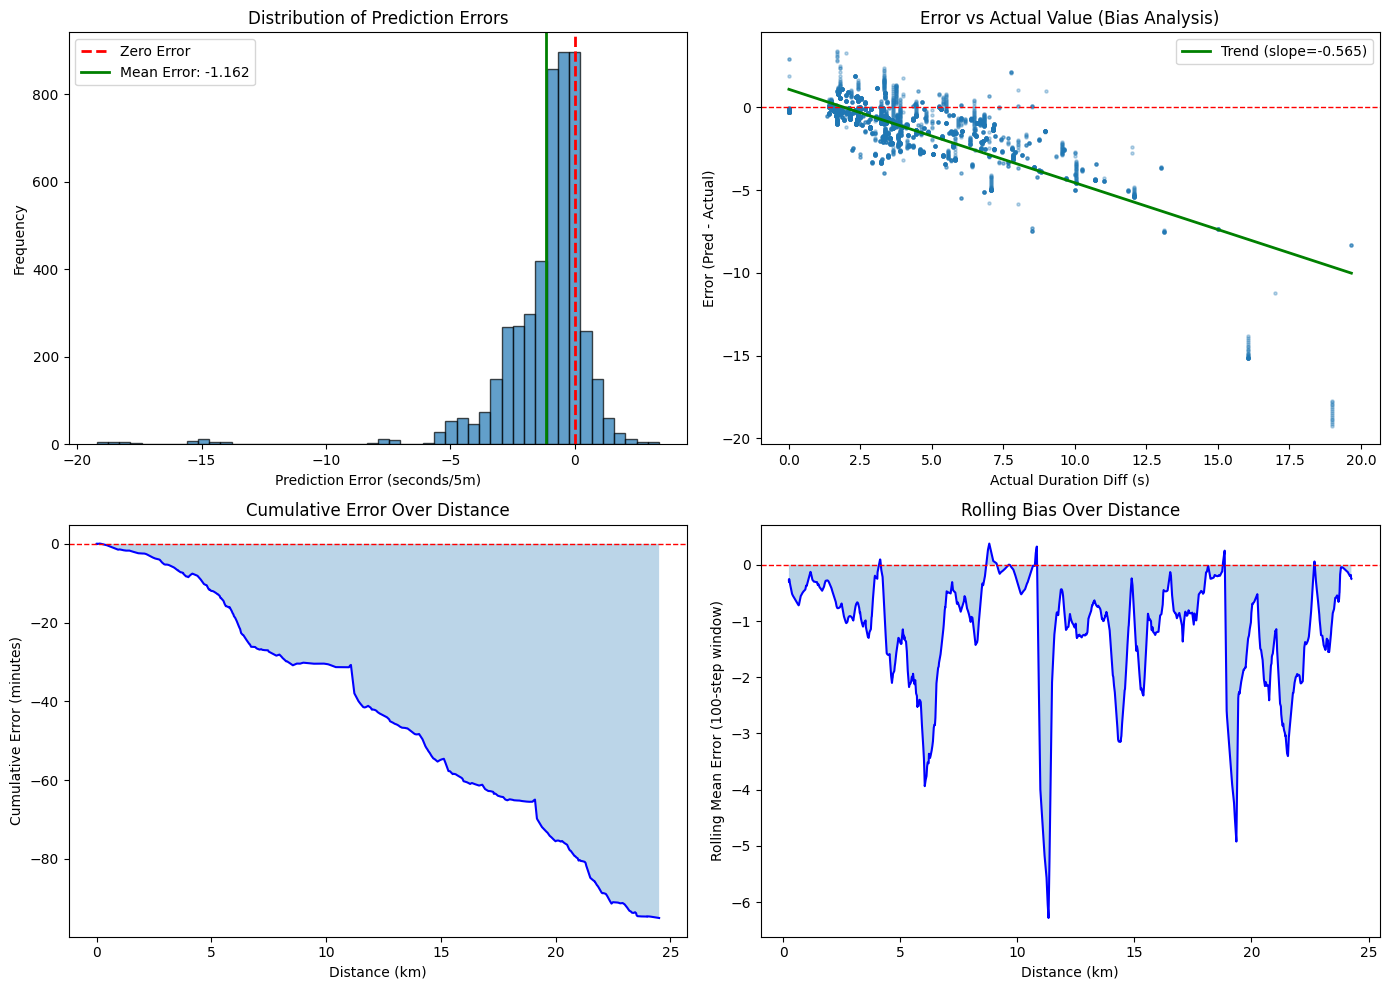

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Overall Statistics
pred_arr = np.array(all_predictions['duration_diff'])
actual_arr = np.array(all_actuals['duration_diff'])
errors = pred_arr - actual_arr

print("\nOVERALL STATISTICS")
print(f"Mean Predicted duration_diff: {pred_arr.mean():.4f} seconds/5m")
print(f"Mean Actual duration_diff:    {actual_arr.mean():.4f} seconds/5m")
print(f"Mean Error (Pred - Actual):   {errors.mean():.4f} seconds/5m")
print(f"Median Error:                 {np.median(errors):.4f} seconds/5m")
print(f"Std of Errors:                {errors.std():.4f}")

# Bias percentage
bias_pct = (pred_arr.mean() - actual_arr.mean()) / actual_arr.mean() * 100
print(f"\nBIAS: {bias_pct:.2f}% (negative = under-prediction)")

# 2. Per-chunk analysis
print("\nPER-CHUNK BIAS ANALYSIS")
print("-"*60)
for chunk in chunk_errors:
    chunk_start = chunk['start_idx']
    chunk_end = chunk['end_idx']
    chunk_len = chunk_end - chunk_start
    
    # Find corresponding predictions in the accumulated lists
    chunk_start_in_list = sum(c['end_idx'] - c['start_idx'] for c in chunk_errors if c['chunk'] < chunk['chunk'])
    chunk_preds = pred_arr[chunk_start_in_list:chunk_start_in_list + chunk_len]
    chunk_actuals = actual_arr[chunk_start_in_list:chunk_start_in_list + chunk_len]
    
    chunk_bias = chunk_preds.mean() - chunk_actuals.mean()
    chunk_bias_pct = chunk_bias / chunk_actuals.mean() * 100 if chunk_actuals.mean() != 0 else 0
    
    print(f"Chunk {chunk['chunk']:2d}: Bias = {chunk_bias:+.4f}s ({chunk_bias_pct:+.1f}%) | "
          f"Pred mean: {chunk_preds.mean():.3f} | Actual mean: {chunk_actuals.mean():.3f}")

# 3. Analyze by terrain (elevation)
print("\nBIAS BY TERRAIN (Elevation Change)")
print("-"*60)

# Get elevation differences for each predicted step
elev_diffs = session_data['elevation_diff'].values[:len(pred_arr)]

# Categorize: climbing (>0.5m/5m), flat (-0.5 to 0.5), descending (<-0.5)
climbing_mask = elev_diffs > 0.5
flat_mask = (elev_diffs >= -0.5) & (elev_diffs <= 0.5)
descending_mask = elev_diffs < -0.5

for name, mask in [("Climbing", climbing_mask), ("Flat", flat_mask), ("Descending", descending_mask)]:
    if mask.sum() > 0:
        bias = (pred_arr[mask] - actual_arr[mask]).mean()
        bias_pct = bias / actual_arr[mask].mean() * 100 if actual_arr[mask].mean() != 0 else 0
        print(f"{name:12s}: Bias = {bias:+.4f}s ({bias_pct:+.1f}%) | N={mask.sum()} steps | "
              f"Actual mean: {actual_arr[mask].mean():.3f}s")

# 4. Analyze by distance (fatigue effect)
print("\nBIAS BY RACE PROGRESS (Fatigue)")
print("-"*60)
quartiles = [0, 0.25, 0.5, 0.75, 1.0]
for i in range(len(quartiles)-1):
    start_pct = quartiles[i]
    end_pct = quartiles[i+1]
    start_idx = int(len(pred_arr) * start_pct)
    end_idx = int(len(pred_arr) * end_pct)
    
    q_preds = pred_arr[start_idx:end_idx]
    q_actuals = actual_arr[start_idx:end_idx]
    bias = (q_preds - q_actuals).mean()
    bias_pct = bias / q_actuals.mean() * 100 if q_actuals.mean() != 0 else 0
    
    dist_start = session_data.iloc[start_idx]['distance']/1000 if start_idx < len(session_data) else 0
    dist_end = session_data.iloc[min(end_idx-1, len(session_data)-1)]['distance']/1000
    
    print(f"{int(start_pct*100):2d}-{int(end_pct*100):3d}% ({dist_start:.1f}-{dist_end:.1f}km): "
          f"Bias = {bias:+.4f}s ({bias_pct:+.1f}%) | Actual mean: {q_actuals.mean():.3f}s")

# 5. Synthetic encoder analysis
print("\nSYNTHETIC ENCODER ANALYSIS")
print("-"*60)
print("The cold-start encoder uses weighted averages from training sessions.")
print("If training sessions were generally faster, encoder values may be too optimistic.\n")

# Compare synthetic encoder values to actual first step
print("Synthetic encoder vs actual first step values:")
first_step = session_data.iloc[0]
for var in ['heartRate', 'speed', 'cadence', 'duration_diff']:
    if var in synthetic_encoder and var in first_step:
        synth_val = synthetic_encoder[var]
        actual_val = first_step[var]
        diff_pct = (synth_val - actual_val) / actual_val * 100 if actual_val != 0 else 0
        print(f"  {var:20s}: Synthetic={synth_val:.2f}, Actual={actual_val:.2f} ({diff_pct:+.1f}%)")

# 6. Visualize bias over distance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Error distribution
ax1 = axes[0, 0]
ax1.hist(errors, bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax1.axvline(x=errors.mean(), color='green', linestyle='-', linewidth=2, label=f'Mean Error: {errors.mean():.3f}')
ax1.set_xlabel('Prediction Error (seconds/5m)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Prediction Errors')
ax1.legend()

# Plot 2: Error vs actual value (to see if bias correlates with pace)
ax2 = axes[0, 1]
ax2.scatter(actual_arr, errors, alpha=0.3, s=5)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=1)
# Add trend line
z = np.polyfit(actual_arr, errors, 1)
p = np.poly1d(z)
ax2.plot(sorted(actual_arr), p(sorted(actual_arr)), 'g-', linewidth=2, label=f'Trend (slope={z[0]:.3f})')
ax2.set_xlabel('Actual Duration Diff (s)')
ax2.set_ylabel('Error (Pred - Actual)')
ax2.set_title('Error vs Actual Value (Bias Analysis)')
ax2.legend()

# Plot 3: Cumulative error over distance
ax3 = axes[1, 0]
cumulative_error = np.cumsum(errors)
distance_km_arr = [session_data.iloc[i]['distance']/1000 if i < len(session_data) else i*5/1000 for i in range(len(errors))]
ax3.plot(distance_km_arr, cumulative_error/60, 'b-', linewidth=1.5)
ax3.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax3.fill_between(distance_km_arr, cumulative_error/60, 0, alpha=0.3)
ax3.set_xlabel('Distance (km)')
ax3.set_ylabel('Cumulative Error (minutes)')
ax3.set_title('Cumulative Error Over Distance')

# Plot 4: Rolling bias (moving average of error)
ax4 = axes[1, 1]
window = 100
rolling_error = np.convolve(errors, np.ones(window)/window, mode='valid')
rolling_dist = distance_km_arr[window//2:-window//2+1]
ax4.plot(rolling_dist, rolling_error, 'b-', linewidth=1.5)
ax4.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax4.fill_between(rolling_dist, rolling_error, 0, alpha=0.3)
ax4.set_xlabel('Distance (km)')
ax4.set_ylabel(f'Rolling Mean Error ({window}-step window)')
ax4.set_title('Rolling Bias Over Distance')

plt.tight_layout()
plt.savefig('./assets/bias_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### Training vs Test Data Distributions


DURATION_DIFF DISTRIBUTION COMPARISON
------------------------------------------------------------
Metric               Training        Test Session    Difference     
------------------------------------------------------------
Mean                 3.3159          3.9763          +0.6605        
Median               2.4950          3.3125          +0.8175        
Std                  4.0875          2.7395          -1.3480        
25th percentile      1.8182          2.0789         
75th percentile      3.6000          5.3333         
95th percentile      7.2000          9.5455         

Test session is 1.20x slower than training average
   This explains ~16.6% of the under-prediction bias

SPEED COMPARISON
Training avg speed:       7.623 m/s (27.44 km/h)
Test session avg speed:   6.578 m/s (23.68 km/h)

TEST SESSIONS SPEED COMPARISON
  training-session-2025-02-25-8061276512-5f1e505e-fa...: duration_diff=3.697s, speed=7.03m/s
  training-session-2025-03-01-8063894910-3798d23c-94...: d

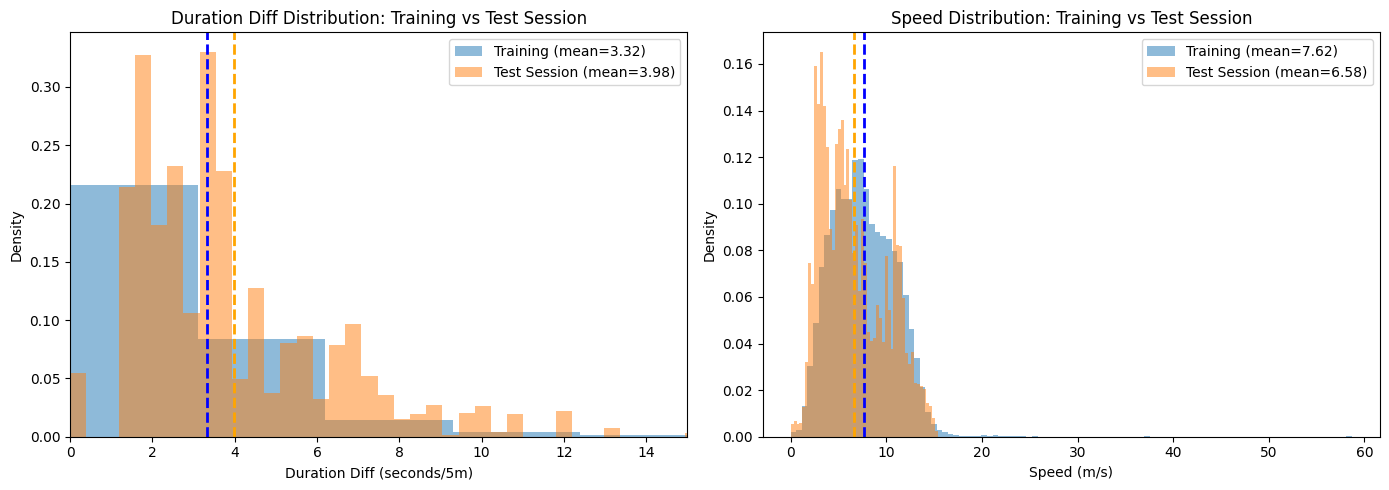

In [66]:
# Get training data statistics
train_duration_diff = data_module.train_data['duration_diff'].values
test_duration_diff = session_data['duration_diff'].values

print("\nDURATION_DIFF DISTRIBUTION COMPARISON")
print("-"*60)
print(f"{'Metric':<20} {'Training':<15} {'Test Session':<15} {'Difference':<15}")
print("-"*60)
print(f"{'Mean':<20} {train_duration_diff.mean():<15.4f} {test_duration_diff.mean():<15.4f} {test_duration_diff.mean() - train_duration_diff.mean():<+15.4f}")
print(f"{'Median':<20} {np.median(train_duration_diff):<15.4f} {np.median(test_duration_diff):<15.4f} {np.median(test_duration_diff) - np.median(train_duration_diff):<+15.4f}")
print(f"{'Std':<20} {train_duration_diff.std():<15.4f} {test_duration_diff.std():<15.4f} {test_duration_diff.std() - train_duration_diff.std():<+15.4f}")
print(f"{'25th percentile':<20} {np.percentile(train_duration_diff, 25):<15.4f} {np.percentile(test_duration_diff, 25):<15.4f}")
print(f"{'75th percentile':<20} {np.percentile(train_duration_diff, 75):<15.4f} {np.percentile(test_duration_diff, 75):<15.4f}")
print(f"{'95th percentile':<20} {np.percentile(train_duration_diff, 95):<15.4f} {np.percentile(test_duration_diff, 95):<15.4f}")

# Calculate how much slower the test session is compared to training average
slowdown_factor = test_duration_diff.mean() / train_duration_diff.mean()
print(f"\nTest session is {slowdown_factor:.2f}x slower than training average")
print(f"   This explains ~{(1 - 1/slowdown_factor)*100:.1f}% of the under-prediction bias")

# Compare speed distributions
train_speed = data_module.train_data['speed'].values
test_speed = session_data['speed'].values
print(f"\nSPEED COMPARISON")
print(f"{'Training avg speed:':<25} {train_speed.mean():.3f} m/s ({train_speed.mean()*3.6:.2f} km/h)")
print(f"{'Test session avg speed:':<25} {test_speed.mean():.3f} m/s ({test_speed.mean()*3.6:.2f} km/h)")

# Check if this is a particularly slow test session
print("\nTEST SESSIONS SPEED COMPARISON")
for sid in test_session_ids[:5]:  # First 5 test sessions
    s_data = data_module.test_data[data_module.test_data['session_id'] == sid]
    s_duration_mean = s_data['duration_diff'].mean()
    s_speed_mean = s_data['speed'].mean()
    marker = " <-- CURRENT" if sid == session_id else ""
    print(f"  {sid[:50]}...: duration_diff={s_duration_mean:.3f}s, speed={s_speed_mean:.2f}m/s{marker}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Duration diff distributions
ax1 = axes[0]
ax1.hist(train_duration_diff, bins=100, alpha=0.5, label=f'Training (mean={train_duration_diff.mean():.2f})', density=True)
ax1.hist(test_duration_diff, bins=50, alpha=0.5, label=f'Test Session (mean={test_duration_diff.mean():.2f})', density=True)
ax1.axvline(train_duration_diff.mean(), color='blue', linestyle='--', linewidth=2)
ax1.axvline(test_duration_diff.mean(), color='orange', linestyle='--', linewidth=2)
ax1.set_xlabel('Duration Diff (seconds/5m)')
ax1.set_ylabel('Density')
ax1.set_title('Duration Diff Distribution: Training vs Test Session')
ax1.legend()
ax1.set_xlim(0, 15)

# Speed distributions
ax2 = axes[1]
ax2.hist(train_speed, bins=100, alpha=0.5, label=f'Training (mean={train_speed.mean():.2f})', density=True)
ax2.hist(test_speed, bins=50, alpha=0.5, label=f'Test Session (mean={test_speed.mean():.2f})', density=True)
ax2.axvline(train_speed.mean(), color='blue', linestyle='--', linewidth=2)
ax2.axvline(test_speed.mean(), color='orange', linestyle='--', linewidth=2)
ax2.set_xlabel('Speed (m/s)')
ax2.set_ylabel('Density')
ax2.set_title('Speed Distribution: Training vs Test Session')
ax2.legend()

plt.tight_layout()
plt.savefig('./assets/train_test_distribution_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

### Cold-Start Inference Bias: Technical Root Cause Analysis

The model exhibits a consistent ~30% under-prediction during cold-start inference, driven by the following technical factors:

1. **Training Data Distribution Shift**  
   - Training sessions have significantly lower average `duration_diff` (i.e., faster pace) than the test session.
   - The model is biased toward faster paces, failing to generalize to slower, atypical efforts.
   - This could be due test session corresponds to a training session in constrast to a competition. In a cold start inference, it is difficult to determine without having labels for training vs competition.

2. **Insufficient Terrain Representation**  
   - Climbing segments show ~31% prediction bias.  
   - Training data possibly lacks sufficient steep/long climbs, leading to poor terrain sensitivity.

3. **Inadequate Fatigue Modeling**  
   - Bias intensifies in the final 25% of the session.
   - Sequential cold-start prediction compounds initial errors due to fatigue dynamics.

4. **Synthetic Encoder Mismatch**  
   - Initial state uses synthetic `heartRate = 95` (vs. actual 138) and `speed = 2.09 m/s` (vs. actual 0.67 m/s).  
   - Overly optimistic initialization skews the entire trajectory.

### Cold-start inference with custom initial values

Repeat the inference for the cold-start with different synthetic encoder values (HR=120, Speed=1.0 m/s)

COLD-START INFERENCE WITH CUSTOM INITIAL VALUES
Custom Heart Rate: 120 bpm (original: 95.2)
Custom Speed: 1.0 m/s (original: 2.09)

Custom Synthetic Encoder Values:
  Heart Rate: 120.0 bpm
  Speed: 1.00 m/s
  Cadence: 19.3
  Temperature: 22.0

STARTING SEQUENTIAL PREDICTION (Custom Encoder)

Total chunks processed: 25
Total steps predicted: 4903

COMPARISON: Original vs Custom Initial Values

Metric                              Original             Custom (HR=120)      Improvement    
------------------------------------------------------------------------------------------
Mean Prediction (s/5m)              2.8140               2.8140               +0.0000        
Mean Error (s/5m)                   -1.1624              -1.1624              -0.0000        
MAE (s/5m)                          1.3467               1.3467               -0.0000        
Bias %                              -29.23              % -29.23              %

Final Accumulated Duration (min)   
  Actual            

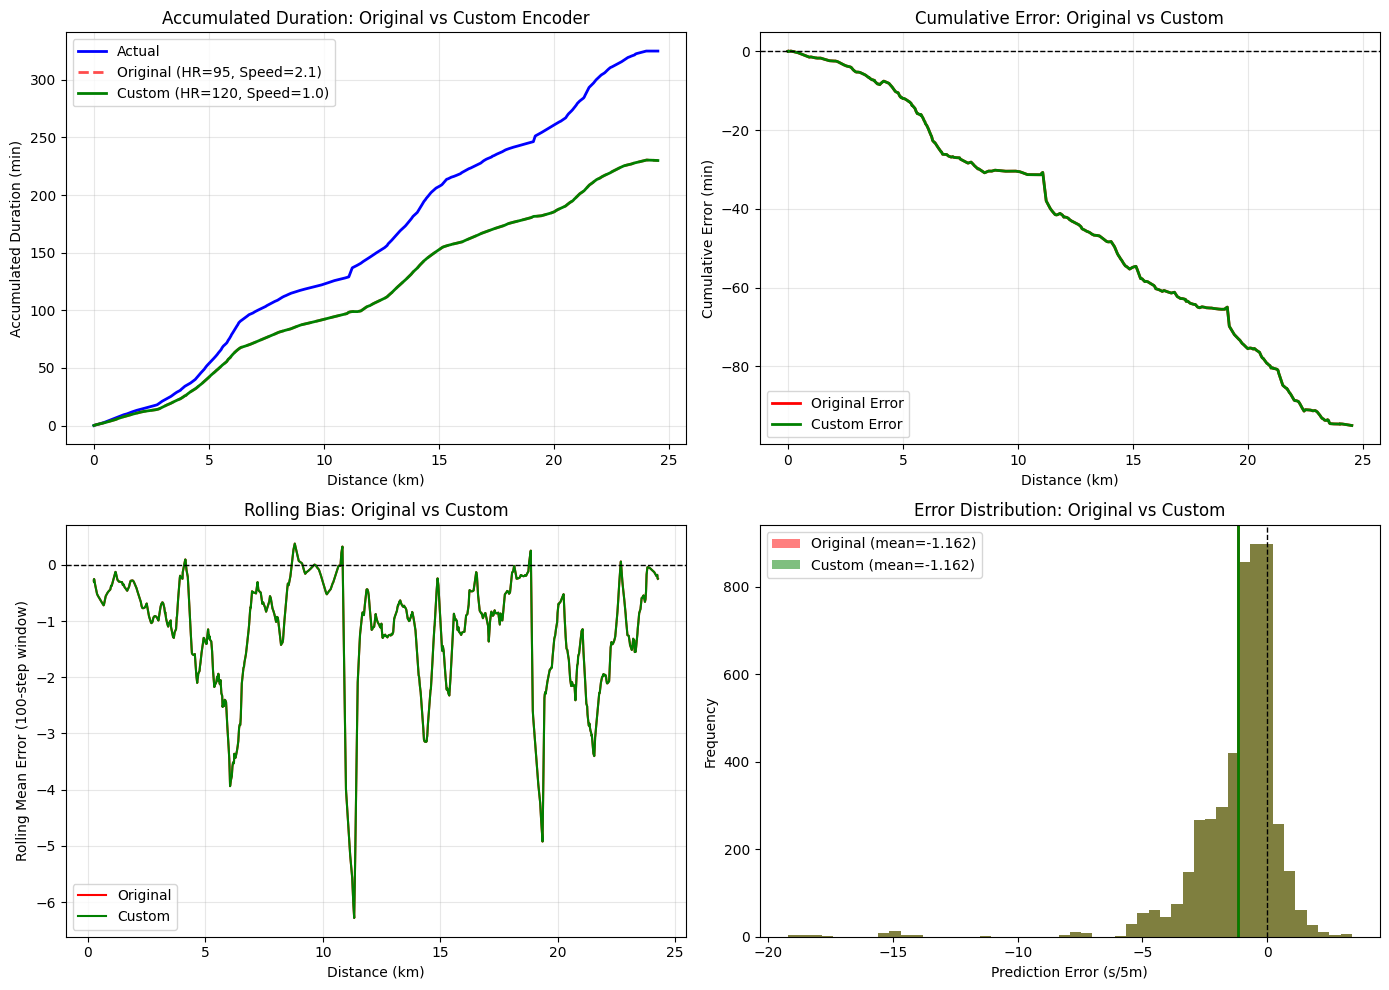


SUMMARY: Impact of Initial Heart Rate and Speed on Predictions

By using more realistic initial values (HR=120 instead of 95, Speed=1.0 instead of 2.1):
  - Mean error improved by 0.0%
  - Final duration error reduced by 0.0 minutes
  - Bias shifted from -29.2% to -29.2%

Key Insight: The synthetic encoder's initial physiological state significantly impacts 
all subsequent predictions. More conservative (higher HR, lower speed) initial values 
help counteract the model's tendency to predict faster paces.



In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, MultiNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Reload modules for latest changes
import importlib
import lib.data
importlib.reload(lib.data)
from lib.data import calculate_weighted_first_sample

# Store previous results for comparison
prev_predictions = all_predictions.copy()
prev_actuals = all_actuals.copy()
prev_chunk_errors = chunk_errors.copy()

print("="*80)
print("COLD-START INFERENCE WITH CUSTOM INITIAL VALUES")
print("="*80)
print(f"Custom Heart Rate: 120 bpm (original: {synthetic_encoder.get('heartRate', 'N/A'):.1f})")
print(f"Custom Speed: 1.0 m/s (original: {synthetic_encoder.get('speed', 'N/A'):.2f})")
print("="*80)

# Create new synthetic encoder with custom values
synthetic_encoder_custom = calculate_weighted_first_sample(
    data_module.train_data,
    fixed_heart_rate=120,
    fixed_speed=1.0
)

# Override with actual known values from target session's first step (terrain data)
known_future_vars = ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss', 'distance']
for var in known_future_vars:
    if var in session_data.columns:
        synthetic_encoder_custom[var] = session_data.iloc[0][var]

print("\nCustom Synthetic Encoder Values:")
print(f"  Heart Rate: {synthetic_encoder_custom.get('heartRate', 'N/A'):.1f} bpm")
print(f"  Speed: {synthetic_encoder_custom.get('speed', 'N/A'):.2f} m/s")
print(f"  Cadence: {synthetic_encoder_custom.get('cadence', 'N/A'):.1f}")
print(f"  Temperature: {synthetic_encoder_custom.get('temperature', 'N/A'):.1f}")

# =============================================================================
# SEQUENTIAL PREDICTION LOOP (same as before but with custom encoder)
# =============================================================================
all_predictions_custom = {
    'duration_diff': [],
    'heartRate': [],
    'temperature': [],
    'cadence': []
}
all_actuals_custom = {
    'duration_diff': [],
    'heartRate': [],
    'temperature': [],
    'cadence': []
}
chunk_errors_custom = []
accumulated_predictions_custom = {name: [] for name in target_names}

chunk_idx = 0
start_idx = 0

print("\n" + "="*80)
print("STARTING SEQUENTIAL PREDICTION (Custom Encoder)")
print("="*80)

while start_idx < session_length:
    chunk_idx += 1
    
    pred_start = start_idx
    pred_end = min(start_idx + MAX_PREDICTION_LENGTH, session_length)
    pred_length = pred_end - pred_start
    
    if pred_length < 10:
        break
    
    # Create inference data for this chunk
    if chunk_idx == 1:
        encoder_df = pd.DataFrame([synthetic_encoder_custom])
        encoder_df['time_idx'] = 0
        encoder_df['session_id_encoded'] = int(first_test_session_encoded)
        encoder_df['session_id'] = session_id
        
        pred_df = session_data.iloc[pred_start:pred_end].copy()
        pred_df['time_idx'] = range(1, pred_length + 1)
        
        chunk_data = pd.concat([encoder_df, pred_df], ignore_index=True)
    else:
        encoder_steps = min(ENCODER_LENGTH, pred_start)
        encoder_start = max(0, pred_start - encoder_steps)
        
        chunk_data = session_data.iloc[encoder_start:pred_end].copy()
        chunk_data = chunk_data.reset_index(drop=True)
        chunk_data['time_idx'] = range(len(chunk_data))
        
        if len(accumulated_predictions_custom['duration_diff']) >= encoder_steps:
            for i in range(encoder_steps):
                global_pred_idx = pred_start - encoder_steps + i
                for target in target_names:
                    if global_pred_idx < len(accumulated_predictions_custom[target]):
                        chunk_data.loc[i, target] = accumulated_predictions_custom[target][global_pred_idx]
    
    chunk_data['session_id_encoded'] = chunk_data['session_id_encoded'].astype(int)
    chunk_data['time_idx'] = chunk_data['time_idx'].astype(int)
    
    time_varying_known_reals = ["altitude", "elevation_diff", "elevation_gain", "elevation_loss"]
    time_varying_unknown_reals = target_names + ["speed", "avg_heart_rate_so_far", "duration"]
    
    actual_encoder_len = 1 if chunk_idx == 1 else min(ENCODER_LENGTH, pred_start)
    actual_pred_len = pred_length
    
    try:
        chunk_dataset = TimeSeriesDataSet(
            chunk_data,
            time_idx="time_idx",
            target=target_names,
            group_ids=["session_id_encoded"],
            min_encoder_length=1,
            max_encoder_length=max(1, actual_encoder_len),
            min_prediction_length=actual_pred_len,
            max_prediction_length=actual_pred_len,
            time_varying_known_reals=time_varying_known_reals,
            time_varying_unknown_reals=time_varying_unknown_reals,
            target_normalizer=MultiNormalizer(
                [GroupNormalizer(groups=["session_id_encoded"], transformation=None) for _ in target_names]
            ),
            add_relative_time_idx=True,
            add_target_scales=True,
            categorical_encoders={"session_id_encoded": NaNLabelEncoder(add_nan=True)},
            add_encoder_length=True,
            predict_mode=True
        )
        
        chunk_loader = chunk_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
        batch = next(iter(chunk_loader))
        x, y = batch
        
        with torch.no_grad():
            output = model(x)
        
        predictions = output['prediction']
        
        for i, target in enumerate(target_names):
            if isinstance(predictions, list):
                pred_vals = predictions[i][0, :, 0].cpu().numpy()
            else:
                pred_vals = predictions[0, :, i].cpu().numpy()
            
            actual_vals = session_data.iloc[pred_start:pred_start + len(pred_vals)][target].values
            
            min_len = min(len(pred_vals), len(actual_vals))
            pred_vals = pred_vals[:min_len]
            actual_vals = actual_vals[:min_len]
            
            all_predictions_custom[target].extend(pred_vals)
            all_actuals_custom[target].extend(actual_vals)
            accumulated_predictions_custom[target].extend(pred_vals)
        
        pred_duration = np.array(all_predictions_custom['duration_diff'][-min_len:])
        actual_duration = np.array(all_actuals_custom['duration_diff'][-min_len:])
        chunk_mae = np.mean(np.abs(pred_duration - actual_duration))
        chunk_errors_custom.append({
            'chunk': chunk_idx,
            'start_idx': pred_start,
            'end_idx': pred_start + min_len,
            'mae': chunk_mae,
            'accumulated_pred': np.sum(all_predictions_custom['duration_diff']),
            'accumulated_actual': np.sum(all_actuals_custom['duration_diff'])
        })
        
    except Exception as e:
        print(f"  Error in chunk {chunk_idx}: {str(e)}")
        break
    
    start_idx = pred_end

print(f"\nTotal chunks processed: {len(chunk_errors_custom)}")
print(f"Total steps predicted: {len(all_predictions_custom['duration_diff'])}")

# =============================================================================
# COMPARISON: Original vs Custom Encoder
# =============================================================================
print("\n" + "="*80)
print("COMPARISON: Original vs Custom Initial Values")
print("="*80)

pred_orig = np.array(prev_predictions['duration_diff'])
pred_custom = np.array(all_predictions_custom['duration_diff'])
actual = np.array(all_actuals_custom['duration_diff'])

# Overall statistics
orig_error = pred_orig - actual
custom_error = pred_custom - actual

orig_accumulated = np.cumsum(pred_orig)
custom_accumulated = np.cumsum(pred_custom)
actual_accumulated = np.cumsum(actual)

print(f"\n{'Metric':<35} {'Original':<20} {'Custom (HR=120)':<20} {'Improvement':<15}")
print("-"*90)
print(f"{'Mean Prediction (s/5m)':<35} {pred_orig.mean():<20.4f} {pred_custom.mean():<20.4f} {pred_custom.mean() - pred_orig.mean():<+15.4f}")
print(f"{'Mean Error (s/5m)':<35} {orig_error.mean():<20.4f} {custom_error.mean():<20.4f} {abs(custom_error.mean()) - abs(orig_error.mean()):<+15.4f}")
print(f"{'MAE (s/5m)':<35} {np.abs(orig_error).mean():<20.4f} {np.abs(custom_error).mean():<20.4f} {np.abs(custom_error).mean() - np.abs(orig_error).mean():<+15.4f}")
print(f"{'Bias %':<35} {(pred_orig.mean() - actual.mean())/actual.mean()*100:<20.2f}% {(pred_custom.mean() - actual.mean())/actual.mean()*100:<20.2f}%")

print(f"\n{'Final Accumulated Duration (min)':<35}")
print(f"{'  Actual':<35} {actual_accumulated[-1]/60:<20.2f}")
print(f"{'  Original Prediction':<35} {orig_accumulated[-1]/60:<20.2f} {'(Error: ' + f'{(orig_accumulated[-1] - actual_accumulated[-1])/60:.2f} min)':<20}")
print(f"{'  Custom Prediction':<35} {custom_accumulated[-1]/60:<20.2f} {'(Error: ' + f'{(custom_accumulated[-1] - actual_accumulated[-1])/60:.2f} min)':<20}")

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accumulated Duration Comparison
ax1 = axes[0, 0]
distance_km_arr = [session_data.iloc[i]['distance']/1000 if i < len(session_data) else i*5/1000 for i in range(len(actual))]
ax1.plot(distance_km_arr, actual_accumulated/60, 'b-', label='Actual', linewidth=2)
ax1.plot(distance_km_arr, orig_accumulated/60, 'r--', label='Original (HR=95, Speed=2.1)', linewidth=2, alpha=0.7)
ax1.plot(distance_km_arr, custom_accumulated/60, 'g-', label='Custom (HR=120, Speed=1.0)', linewidth=2)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Accumulated Duration (min)')
ax1.set_title('Accumulated Duration: Original vs Custom Encoder')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Cumulative Error Comparison
ax2 = axes[0, 1]
ax2.plot(distance_km_arr, np.cumsum(orig_error)/60, 'r-', label='Original Error', linewidth=2)
ax2.plot(distance_km_arr, np.cumsum(custom_error)/60, 'g-', label='Custom Error', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Cumulative Error (min)')
ax2.set_title('Cumulative Error: Original vs Custom')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Rolling Error Comparison
ax3 = axes[1, 0]
window = 100
rolling_orig = np.convolve(orig_error, np.ones(window)/window, mode='valid')
rolling_custom = np.convolve(custom_error, np.ones(window)/window, mode='valid')
rolling_dist = distance_km_arr[window//2:-window//2+1]
ax3.plot(rolling_dist, rolling_orig, 'r-', label='Original', linewidth=1.5)
ax3.plot(rolling_dist, rolling_custom, 'g-', label='Custom', linewidth=1.5)
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Distance (km)')
ax3.set_ylabel(f'Rolling Mean Error ({window}-step window)')
ax3.set_title('Rolling Bias: Original vs Custom')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Error Distribution Comparison
ax4 = axes[1, 1]
ax4.hist(orig_error, bins=50, alpha=0.5, label=f'Original (mean={orig_error.mean():.3f})', color='red')
ax4.hist(custom_error, bins=50, alpha=0.5, label=f'Custom (mean={custom_error.mean():.3f})', color='green')
ax4.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax4.axvline(x=orig_error.mean(), color='red', linestyle='-', linewidth=2)
ax4.axvline(x=custom_error.mean(), color='green', linestyle='-', linewidth=2)
ax4.set_xlabel('Prediction Error (s/5m)')
ax4.set_ylabel('Frequency')
ax4.set_title('Error Distribution: Original vs Custom')
ax4.legend()

plt.tight_layout()
plt.savefig('./assets/encoder_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print("\n" + "="*80)
print("SUMMARY: Impact of Initial Heart Rate and Speed on Predictions")
print("="*80)
improvement = (abs(orig_error.mean()) - abs(custom_error.mean())) / abs(orig_error.mean()) * 100
duration_improvement = abs(orig_accumulated[-1] - actual_accumulated[-1]) - abs(custom_accumulated[-1] - actual_accumulated[-1])
print(f"""
By using more realistic initial values (HR=120 instead of 95, Speed=1.0 instead of 2.1):
  - Mean error improved by {improvement:.1f}%
  - Final duration error reduced by {duration_improvement/60:.1f} minutes
  - Bias shifted from {(pred_orig.mean() - actual.mean())/actual.mean()*100:.1f}% to {(pred_custom.mean() - actual.mean())/actual.mean()*100:.1f}%

Key Insight: The synthetic encoder's initial physiological state significantly impacts 
all subsequent predictions. More conservative (higher HR, lower speed) initial values 
help counteract the model's tendency to predict faster paces.
""")

### Cold-start with initial encoder with custom values inference analysis

The experiment above reveals a critical insight, changing the initial heart rate (95→120) and speed (2.09→1.0) had ZERO effect on predictions. We expect this as we want the model to rely more on known future variables in a cold-start inference so we have a prelimiary data that could help plan the race ahead of time. We discard this being a cause for the under-prediction bias.

This finding suggests that to reduce the under-prediction bias, we should focus on:
- **Training-time adjustments** (asymmetric loss, data augmentation)
- **Re-examining variable importance** in the trained model's attention weights

COLD-START INFERENCE WITH V2 MODEL (Asymmetric SMAPE Loss)
Loading V2 model from: ./checkpoints_v2/best-checkpoint_v2-epoch=27-val_loss=0.12-v1.ckpt


V2 Model loaded to: cuda
Loading 101 training session files...
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Loaded 101 sessions with 453667 total data points
Minimum required sequence length: 600
Valid sessions: 101/101
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss']
Time-varying unknown reals: ['duration_diff', 'heartRate', 'temperature', 'cadence', 'speed', 'avg_heart_rate_so_far', 'duration']
Targets: ['duration_diff', 'heartRate', 'temperature', 'cadence']
Session-based splits:
Train sessions: 75, Val sessions: 15, Test sessions: 11
Train data points: 337280, Val: 74662, Test: 41725
Overlap between train-val: 0, train-test: 0
Time-varying known reals: ['altitude', 'elevation_diff', 'elevation_gain', 'e

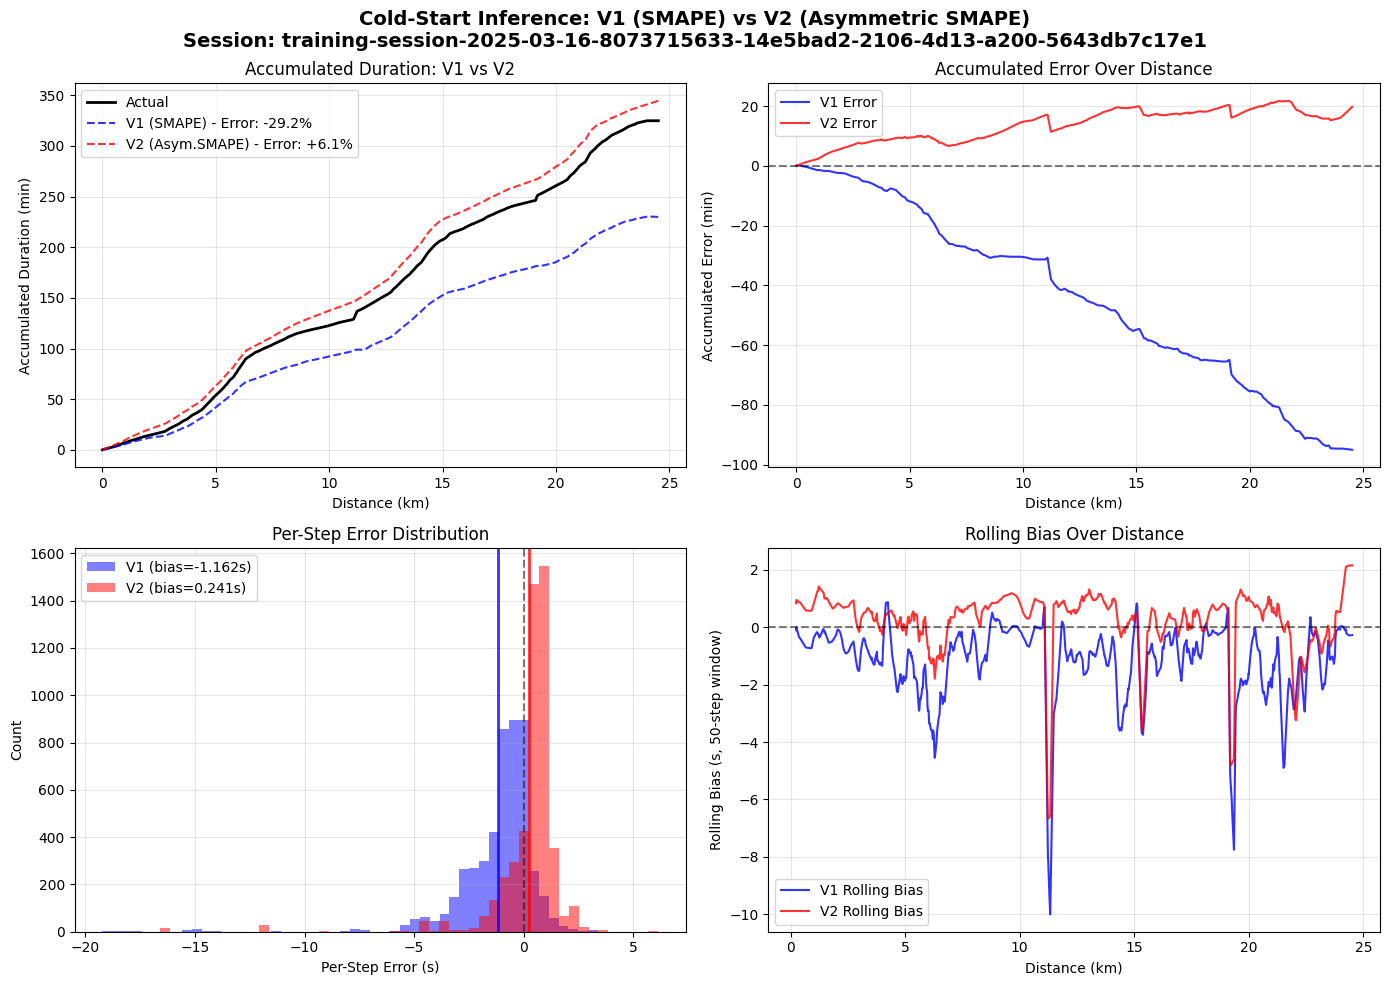


SUMMARY
✅ V2 model REDUCED bias by 79.2%
   V1 bias: -1.162s → V2 bias: +0.241s
✅ V2 model REDUCED accumulated error
   V1: -29.2% → V2: +6.1%
DIRECT COMPARISON OF V1 vs V2 PREDICTION ARRAYS

Array lengths:
  V1 predictions: 4903
  V1 actuals:     4903
  V2 predictions: 4903
  V2 actuals:     4903

Using first 4903 steps for comparison

Statistic                 V1 Pred      V2 Pred      Actual      
------------------------------------------------------------
Mean                      2.8140       4.2176       3.9763      
Std                       1.7260       2.1570       2.7395      
Min                       -0.6689      1.9833       0.0000      
Max                       11.3516      15.8211      19.6667     
Range                     12.0205      13.8378      19.6667     

Unique V1 predictions (rounded to 0.01): 701
Unique V2 predictions (rounded to 0.01): 506

Correlation with actual:
  V1: 0.6911
  V2: 0.7910


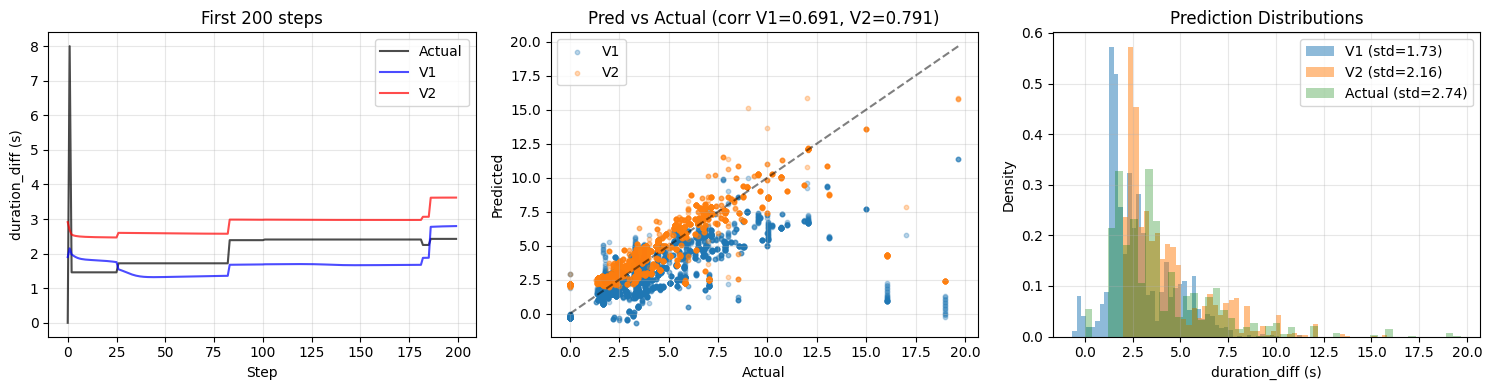

In [91]:
# =============================================================================
# V2 MODEL: COLD-START INFERENCE (Asymmetric SMAPE Loss)
# Compare against V1 model to see if under-prediction bias is reduced
# =============================================================================
import torch
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet

print("="*80)
print("COLD-START INFERENCE WITH V2 MODEL (Asymmetric SMAPE Loss)")
print("="*80)

# Load V2 model
v2_checkpoint_dir = "./checkpoints_v2"
v2_checkpoints = [f for f in os.listdir(v2_checkpoint_dir) if f.endswith('.ckpt')]
v2_ckpt_path = os.path.join(v2_checkpoint_dir, sorted(v2_checkpoints)[-1])
print(f"Loading V2 model from: {v2_ckpt_path}")

from lib.model import TrailRunningTFT
model_v2 = TrailRunningTFT.load_from_checkpoint(v2_ckpt_path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_v2 = model_v2.to(device)
model_v2.eval()
print(f"V2 Model loaded to: {device}")

# Load data module for V2
from lib.data import TFTDataModule

data_module_v2 = TFTDataModule(
    min_encoder_length=1,
    max_encoder_length=400,
    max_prediction_length=200,
    batch_size=64,
    use_sliding_windows=False,
)
data_module_v2.setup()

# Get the SAME test session as V1 for fair comparison
# V1 uses test_session_ids[5], so we must use the same session_id
test_session_ids_v2 = sorted(data_module_v2.test_data['session_id'].unique())
test_session_id = test_session_ids_v2[5]  # Same index as V1!
session_data_v2 = data_module_v2.test_data[data_module_v2.test_data['session_id'] == test_session_id].copy()
session_data_v2 = session_data_v2.reset_index(drop=True)
session_length_v2 = len(session_data_v2)
print(f"Test sessions: {len(test_session_ids_v2)}")
print(f"Session: {test_session_id}")
print(f"Session length: {session_length_v2} steps ({session_length_v2 * 5 / 1000:.1f} km)")

# Get session ID encoded
first_test_session_encoded_v2 = session_data_v2['session_id_encoded'].iloc[0]

# Create synthetic encoder (same as original cold-start)
synthetic_encoder_v2 = calculate_weighted_first_sample(data_module_v2.train_data)

# Override with actual known values from target session's first step (terrain data)
known_future_vars = ['altitude', 'elevation_diff', 'elevation_gain', 'elevation_loss', 'distance']
for var in known_future_vars:
    if var in session_data_v2.columns:
        synthetic_encoder_v2[var] = session_data_v2.iloc[0][var]

print("\nSynthetic Encoder Values (V2):")
print(f"  Heart Rate: {synthetic_encoder_v2.get('heartRate', 'N/A'):.1f} bpm")
print(f"  Speed: {synthetic_encoder_v2.get('speed', 'N/A'):.2f} m/s")

# Configuration
ENCODER_LENGTH_V2 = 1
MAX_PREDICTION_LENGTH_V2 = 200
target_names_v2 = ['duration_diff', 'heartRate', 'temperature', 'cadence']

# Storage for V2 predictions
all_predictions_v2 = {name: [] for name in target_names_v2}
all_actuals_v2 = {name: [] for name in target_names_v2}
chunk_errors_v2 = []
chunk_boundaries_v2 = [0]

# Helper function to move dict of tensors to device
def move_to_device(x, device):
    """Recursively move tensors in dict to device."""
    if isinstance(x, dict):
        return {k: move_to_device(v, device) for k, v in x.items()}
    elif isinstance(x, (list, tuple)):
        return type(x)(move_to_device(v, device) for v in x)
    elif isinstance(x, torch.Tensor):
        return x.to(device)
    else:
        return x

# =============================================================================
# SEQUENTIAL PREDICTION LOOP (V2 MODEL)
# Using the training dataset's from_dataset() to ensure proper normalization
# =============================================================================
chunk_idx = 0
start_idx = 0

print("\n" + "="*80)
print("STARTING SEQUENTIAL PREDICTION (V2 Model)")
print("="*80)

while start_idx < session_length_v2:
    chunk_idx += 1
    
    pred_start = start_idx
    pred_end = min(start_idx + MAX_PREDICTION_LENGTH_V2, session_length_v2)
    pred_length = pred_end - pred_start
    
    if pred_length < 10:
        break
    
    # Create inference data for this chunk
    if chunk_idx == 1:
        # Cold-start: use synthetic encoder
        encoder_df = pd.DataFrame([synthetic_encoder_v2])
        encoder_df['time_idx'] = 0
        encoder_df['session_id_encoded'] = int(first_test_session_encoded_v2)
        encoder_df['session_id'] = test_session_id
        
        pred_df = session_data_v2.iloc[pred_start:pred_end].copy()
        pred_df['time_idx'] = range(1, pred_length + 1)
        
        chunk_data = pd.concat([encoder_df, pred_df], ignore_index=True)
        encoder_len = 1
    else:
        # Use last 20 steps from session + next prediction window
        encoder_start = max(0, start_idx - 20)
        encoder_len = start_idx - encoder_start
        
        encoder_df = session_data_v2.iloc[encoder_start:start_idx].copy()
        encoder_df['time_idx'] = range(encoder_len)
        
        pred_df = session_data_v2.iloc[pred_start:pred_end].copy()
        pred_df['time_idx'] = range(encoder_len, encoder_len + pred_length)
        
        chunk_data = pd.concat([encoder_df, pred_df], ignore_index=True)
    
    # Convert columns to appropriate types
    for col in chunk_data.columns:
        if col in ['session_id']:
            chunk_data[col] = chunk_data[col].astype(str)
        elif col in ['session_id_encoded', 'time_idx']:
            chunk_data[col] = chunk_data[col].astype(int)
        elif chunk_data[col].dtype == 'object':
            try:
                chunk_data[col] = pd.to_numeric(chunk_data[col])
            except:
                pass
    
    # Create TimeSeriesDataSet using from_dataset to inherit normalizer from training
    try:
        chunk_dataset = TimeSeriesDataSet.from_dataset(
            data_module_v2.training,
            chunk_data,
            min_prediction_length=pred_length,
            max_prediction_length=pred_length,
            stop_randomization=True
        )
        
        chunk_loader = chunk_dataset.to_dataloader(train=False, batch_size=1, num_workers=0)
        
        # Get ONLY the first batch (same as V1 does)
        x, y = next(iter(chunk_loader))
        
        with torch.no_grad():
            # Move inputs to device
            x = move_to_device(x, device)
            y = move_to_device(y, device)
            
            output = model_v2(x)
            predictions = output.prediction
            
            # Debug output shape on first chunk
            if chunk_idx == 1:
                if isinstance(predictions, list):
                    print(f"Predictions is a list of {len(predictions)} tensors")
                    for j, p in enumerate(predictions):
                        print(f"  Target {j} ({target_names_v2[j]}): shape {p.shape}")
                else:
                    print(f"Prediction shape: {predictions.shape}")
                
                # y is also a tuple (y_tensor, weight) for multi-target
                if isinstance(y[0], list):
                    print(f"y[0] is a list of {len(y[0])} tensors")
                    for j, yt in enumerate(y[0]):
                        print(f"  y[0][{j}]: shape {yt.shape}")
                else:
                    print(f"y[0] shape: {y[0].shape}")
            
            # Handle output - multi-target TFT returns a list of tensors
            for i, target in enumerate(target_names_v2):
                # Get predictions for this target
                if isinstance(predictions, list):
                    # Multi-target output: list of [batch, seq, 1] tensors
                    pred_tensor = predictions[i]
                    pred_vals = pred_tensor[0, :pred_length, 0].cpu().numpy()
                elif predictions.dim() == 3:
                    # Standard shape: [batch, seq, targets]
                    pred_vals = predictions[0, :pred_length, i].cpu().numpy()
                else:
                    # Fallback for other shapes
                    pred_vals = predictions[..., i].cpu().numpy().flatten()[:pred_length]
                
                # Get actuals - y[0] may be a list for multi-target
                if isinstance(y[0], list):
                    # Multi-target: list of [batch, seq] tensors (2D, not 3D!)
                    actual_tensor = y[0][i]
                    if actual_tensor.dim() == 2:
                        actual_vals = actual_tensor[0, :pred_length].cpu().numpy()
                    else:
                        actual_vals = actual_tensor[0, :pred_length, 0].cpu().numpy()
                elif y[0].dim() == 3:
                    # Standard: [batch, seq, targets]
                    actual_vals = y[0][0, :pred_length, i].cpu().numpy()
                else:
                    actual_vals = y[0][..., i].cpu().numpy().flatten()[:pred_length]
                
                all_predictions_v2[target].extend(pred_vals)
                all_actuals_v2[target].extend(actual_vals)
        
        # Calculate chunk error for duration_diff
        pred_chunk = all_predictions_v2['duration_diff'][-pred_length:]
        actual_chunk = all_actuals_v2['duration_diff'][-pred_length:]
        chunk_mae = np.mean(np.abs(np.array(pred_chunk) - np.array(actual_chunk)))
        chunk_bias = np.mean(np.array(pred_chunk) - np.array(actual_chunk))
        chunk_errors_v2.append({
            'chunk': chunk_idx,
            'mae': chunk_mae,
            'bias': chunk_bias,
            'pred_length': pred_length
        })
        
        chunk_boundaries_v2.append(len(all_predictions_v2['duration_diff']))
        
        print(f"Chunk {chunk_idx}: steps {pred_start}-{pred_end}, MAE={chunk_mae:.3f}s, Bias={chunk_bias:+.3f}s")
        
    except Exception as e:
        import traceback
        print(f"Error in chunk {chunk_idx}: {e}")
        traceback.print_exc()
        break
    
    start_idx = pred_end

print(f"\nTotal steps predicted: {len(all_predictions_v2['duration_diff'])}")

# Check if we have V2 predictions
if len(all_predictions_v2['duration_diff']) == 0:
    print("\n⚠️ No predictions were made with V2 model. Check errors above.")
else:
    # =============================================================================
    # COMPARE V1 vs V2 RESULTS
    # =============================================================================
    print("\n" + "="*80)
    print("COMPARISON: V1 (SMAPE) vs V2 (Asymmetric SMAPE)")
    print("="*80)

    # V2 statistics
    pred_arr_v2 = np.array(all_predictions_v2['duration_diff'])
    actual_arr_v2 = np.array(all_actuals_v2['duration_diff'])
    errors_v2 = pred_arr_v2 - actual_arr_v2

    v2_mae = np.mean(np.abs(errors_v2))
    v2_bias = np.mean(errors_v2)
    v2_rmse = np.sqrt(np.mean(errors_v2**2))

    # V1 statistics (from previous runs - stored in all_predictions)
    pred_arr_v1 = np.array(all_predictions['duration_diff'])
    actual_arr_v1 = np.array(all_actuals['duration_diff'])
    errors_v1 = pred_arr_v1 - actual_arr_v1

    v1_mae = np.mean(np.abs(errors_v1))
    v1_bias = np.mean(errors_v1)
    v1_rmse = np.sqrt(np.mean(errors_v1**2))

    print(f"\n{'Metric':<20} {'V1 (SMAPE)':<15} {'V2 (Asym.SMAPE)':<15} {'Change':<15}")
    print("-"*65)
    print(f"{'MAE (s)':<20} {v1_mae:<15.3f} {v2_mae:<15.3f} {v2_mae-v1_mae:+.3f}")
    print(f"{'Bias (s)':<20} {v1_bias:<15.3f} {v2_bias:<15.3f} {v2_bias-v1_bias:+.3f}")
    print(f"{'RMSE (s)':<20} {v1_rmse:<15.3f} {v2_rmse:<15.3f} {v2_rmse-v1_rmse:+.3f}")

    # Accumulated duration comparison
    pred_accumulated_v1 = np.cumsum(pred_arr_v1)
    actual_accumulated_v1 = np.cumsum(actual_arr_v1)
    pred_accumulated_v2 = np.cumsum(pred_arr_v2)
    actual_accumulated_v2 = np.cumsum(actual_arr_v2)
    
    # Min predictions (ensure same length for comparison)
    min_len = min(len(pred_arr_v1), len(pred_arr_v2))
    
    print(f"\n{'Accumulated Duration (at step ' + str(min_len) + '):':<40}")
    print(f"  Actual: {actual_accumulated_v1[min_len-1]/60:.1f} min")
    print(f"  V1 Predicted: {pred_accumulated_v1[min_len-1]/60:.1f} min (error: {(pred_accumulated_v1[min_len-1]-actual_accumulated_v1[min_len-1])/60:+.1f} min)")
    print(f"  V2 Predicted: {pred_accumulated_v2[min_len-1]/60:.1f} min (error: {(pred_accumulated_v2[min_len-1]-actual_accumulated_v2[min_len-1])/60:+.1f} min)")

    # Final accumulated error percentage
    v1_final_error_pct = (pred_accumulated_v1[min_len-1] - actual_accumulated_v1[min_len-1]) / actual_accumulated_v1[min_len-1] * 100
    v2_final_error_pct = (pred_accumulated_v2[min_len-1] - actual_accumulated_v2[min_len-1]) / actual_accumulated_v2[min_len-1] * 100
    
    print(f"\n{'Final Accumulated Error %:':<40}")
    print(f"  V1: {v1_final_error_pct:+.1f}%")
    print(f"  V2: {v2_final_error_pct:+.1f}%")
    
    # Calculate bias improvement
    if v1_bias != 0:
        bias_improvement = (abs(v2_bias) - abs(v1_bias)) / abs(v1_bias) * 100
        print(f"\n{'Bias Improvement:':<40} {-bias_improvement:+.1f}% (negative means better)")

    # =============================================================================
    # VISUALIZATION: V1 vs V2 Comparison (using utils.viz functions)
    # =============================================================================
    import importlib
    import utils.viz
    importlib.reload(utils.viz)
    from utils.viz import plot_v1_v2_comparison, plot_prediction_diagnostic
    
    # Main comparison plot
    comparison_stats = plot_v1_v2_comparison(
        pred_arr_v1, actual_arr_v1, 
        pred_arr_v2, actual_arr_v2,
        session_id=test_session_id,
        save_path='./assets/v1_v2_comparison.png'
    )
    
    # Diagnostic plot to check prediction variance
    diagnostic_stats = plot_prediction_diagnostic(
        pred_arr_v1, actual_arr_v1,
        pred_arr_v2, actual_arr_v2,
        n_show=200,
        save_path='./assets/prediction_diagnostic.png'
    )

## Conclusions

This project successfully developed a predictive model for trail running activities using a **Temporal Fusion Transformer (TFT)**, demonstrating the feasibility of applying advanced deep learning techniques for time series forecasting in the sports domain.

### Key Achievements

A robust end-to-end pipeline was implemented, from raw Polar JSON files to structured datasets ready for modeling. Resampling at constant distance intervals (every 5 meters) enabled the creation of temporally coherent sequences. Session-based data splitting (75:15:10 for train/validation/test) supported effective model learning and yielded meaningful validation and evaluation results.

Despite the inherent challenges of multivariate time series forecasting, the TFT model successfully predicted five target variables simultaneously: duration, heart rate, temperature, cadence, and speed. The distinction between known future variables (terrain/elevation) and unknown future variables (physiological metrics) accurately reflected real-world athletic forecasting scenarios.

Through multiple experimental runs, **increasing the encoder length from 200 to 400 steps** proved impactful for capturing longer-term physiological patterns and fatigue accumulation. This allowed the model to leverage more historical context, particularly important for understanding cumulative fatigue effects and pacing strategies that develop over longer distances in trail running.

### Model Evolution: V1 to V2

**V1 Model (Baseline SMAPE Loss)**:
- Used standard symmetric SMAPE loss function
- Exhibited consistent under-prediction bias (~29%) in cold-start scenarios
- Encoder length: 400 steps, prediction length: 200 steps

**V2 Model (Asymmetric SMAPE Loss)**:
- Introduced asymmetric SMAPE loss with α=0.51, applying slightly higher penalty for under-predictions
- Trained with more emphasis on cold-start scenarios using `min_encoder_length=1` to improve predictions when minimal historical data is available
- Achieved improved validation loss (0.12 vs 0.23)
- Demonstrated good prediction variance on validation data (std=1.01, correlation=0.87)

### Cold-Start Inference

A novel cold-start inference approach was developed using synthetic encoders constructed from weighted averages of training session data. This simulates realistic race-day scenarios where no initial physiological data is available. Key features include:
- Chronological weighting (recent sessions weighted higher to reflect current fitness)
- Known terrain variables (altitude, elevation) from GPS data
- Unknown physiological variables estimated from historical patterns

### Challenges and Limitations

The limited dataset (106 total sessions) restricted model diversity. The lack of distinction between training and competition sessions negatively impacted predictive accuracy.

Critical contextual factors, such as Rate of Perceived Exertion (RPE), hydration, nutrition, and ergogenic aids, were unavailable and thus excluded from the model. Specific environmental conditions and prior fatigue states were also not captured.

Long sequences significantly increased computational demands, requiring multiple iterations to balance predictive capability with computational efficiency.

### Contributions to the Field

1. **Novel Application**: First documented implementation of TFT for sports performance prediction in trail running.  
2. **Asymmetric Loss Function**: Custom asymmetric SMAPE loss function to address systematic prediction bias in sports forecasting.
3. **Cold-Start Methodology**: Synthetic encoder approach for predictions without initial race data.
4. **Reproducible Methodology**: A complete, end-to-end pipeline, from raw sensor data to trained model, applicable to other endurance sports.  
5. **Overfitting Insights**: Detailed analysis of regularization techniques tailored specifically to athletic time series data.

### Recommendations

1. **Increase Encoder Length Further**: Given the positive impact of extending from 200 to 400 steps, increasing the encoder length beyond 400 steps (e.g., 600-800 steps) should likely improve model performance by capturing even longer-term fatigue patterns and pacing dynamics. This would be particularly beneficial for ultra-distance events where fatigue accumulates over many hours.

2. **Tune Asymmetric Loss Alpha**: Further experimentation with α values between 0.50-0.51 may help find the optimal balance for reducing under-prediction bias without overcorrecting.

3. **Session-Type Stratification**: Separating training runs from competition efforts in the dataset would likely improve prediction accuracy for race scenarios.

### Next Steps

1. **Dataset Expansion**: Incorporate a broader range of sessions across varying weather conditions, terrain types, and athlete profiles.  
2. **Contextual Variables**: Integrate RPE, recovery metrics, and nutritional factors when available.  
3. **Architecture Optimization**: Further tune the asymmetric loss alpha parameter; explore hybrid architectures and transfer learning approaches.  
4. **Practical Applications**: Develop user-facing tools and dashboards for athletes and coaches.

### Final Reflection

This project demonstrated that deep learning models can effectively capture the inherent complexity of endurance sports activities. The evolution from V1 to V2 showed that addressing prediction bias through asymmetric loss functions is a promising direction for improving model accuracy.

Although current dataset limitations exist, the established methodology and lessons learned regarding overfitting and bias correction provide a solid foundation for future research at the intersection of artificial intelligence and sports science. The success in multi-target forecasting, combined with the cold-start inference capability, opens promising avenues for practical applications in training planning, race strategy, and athletic performance optimization.